# Task 2 : Multimodal Idiomaticity Representation

**Project Setup Guide**

1. Unzipping and Uploading the Project

  - Unzip the `CSC8645_Chatwipa.zip` file.
  - Upload the extracted folder to your Google Drive, maintaining the following structure:

```
drive
|- Coursework_chatwipa
|  |- TASK 1
|  |  
|  |- TASK 2
|  |  |- demo_test
|  |  |  |- images #choice of images
|  |  |  |- test.xlsx #exel file for store the text input
|  |  |  
|  |  |- model # store trained model
|  |  |- dataset # store result from data augmentation
|  |  |  |- balanced_train_augmented.csv
|  |  |  |- imbalanced_train_augmented.csv
|  |  |
|  |  |- TASK 2.ipynb
```

2. Uploading Additional Data

    - Place the dataset zip files (`Task 2 NLP Dataset.zip`) into the `dataset` folder.
    - The final folder structure should be:

```
drive
|- Coursework_chatwipa
|  |- TASK 1
|  |  
|  |- TASK 2
|  |  |- demo_test
|  |  |  |- images #choice of images
|  |  |  |- test.xlsx #exel file for store the text input
|  |  |  
|  |  |- model # store trained model
|  |  |- dataset # store result from data augmentation
|  |  |  |- balanced_train_augmented.csv
|  |  |  |- imbalanced_train_augmented.csv
|  |  |  |- Task 2 NLP Dataset.zip
|  |  |
|  |  |- TASK 2.ipynb
```

3. Install package and load library in `Step 0`

4. Running the Demonstration

  - Navigate to the **Demonstration** section of the notebook to test the process before proceeding further.

# Step 0: Install packages and load data

In [1]:
%pip install git+https://github.com/openai/CLIP.git
%pip install numpy pandas scikit-learn

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-54vb81v6
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-54vb81v6
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [2]:
# Library for calculation
import os
import zipfile
import pandas as pd
import numpy as np
from datetime import datetime

# Library for image and plotting
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

# Library for evaluation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Library for model
from collections import Counter
from wordcloud import WordCloud
import re
import string
import clip
import random
import spacy
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
from torchvision import transforms
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from transformers import ViTFeatureExtractor, ViTForImageClassification
from transformers import T5Tokenizer
from PIL import Image

#### Load datasets

- Download the datasets from canvas page https://ncl.instructure.com/courses/58651/files/9259194?wrap=1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_zip = "/content/drive/MyDrive/CSC8645_Chatwipa/TASK 2/dataset/Task 2 NLP Dataset.zip"

# Unzip dataset from drive to disk
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

In [ ]:
# Load datasets
fpath="/content/dataset/" # Adjust paths
train_path= fpath+"train/train.csv"
val_path= fpath+"val/val.csv"
test_path= fpath+"test/test.csv"
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

In [ ]:
# show the data
print(test_df)

             compound sentence_type  \
0         dirty money     idiomatic   
1         dirty money     idiomatic   
2         dirty money     idiomatic   
3        secret santa     idiomatic   
4        secret santa     idiomatic   
5        secret santa     idiomatic   
6         ivory tower     idiomatic   
7         ivory tower     idiomatic   
8         ivory tower     idiomatic   
9   low-hanging fruit     idiomatic   
10  low-hanging fruit     idiomatic   
11  low-hanging fruit     idiomatic   
12         brass ring     idiomatic   
13         brass ring     idiomatic   
14         brass ring     idiomatic   
15      silver bullet     idiomatic   
16      silver bullet     idiomatic   
17      silver bullet     idiomatic   
18      peas in a pod     idiomatic   
19      peas in a pod     idiomatic   
20      peas in a pod     idiomatic   
21        green light     idiomatic   
22        green light     idiomatic   
23        green light     idiomatic   
24           busy bee    

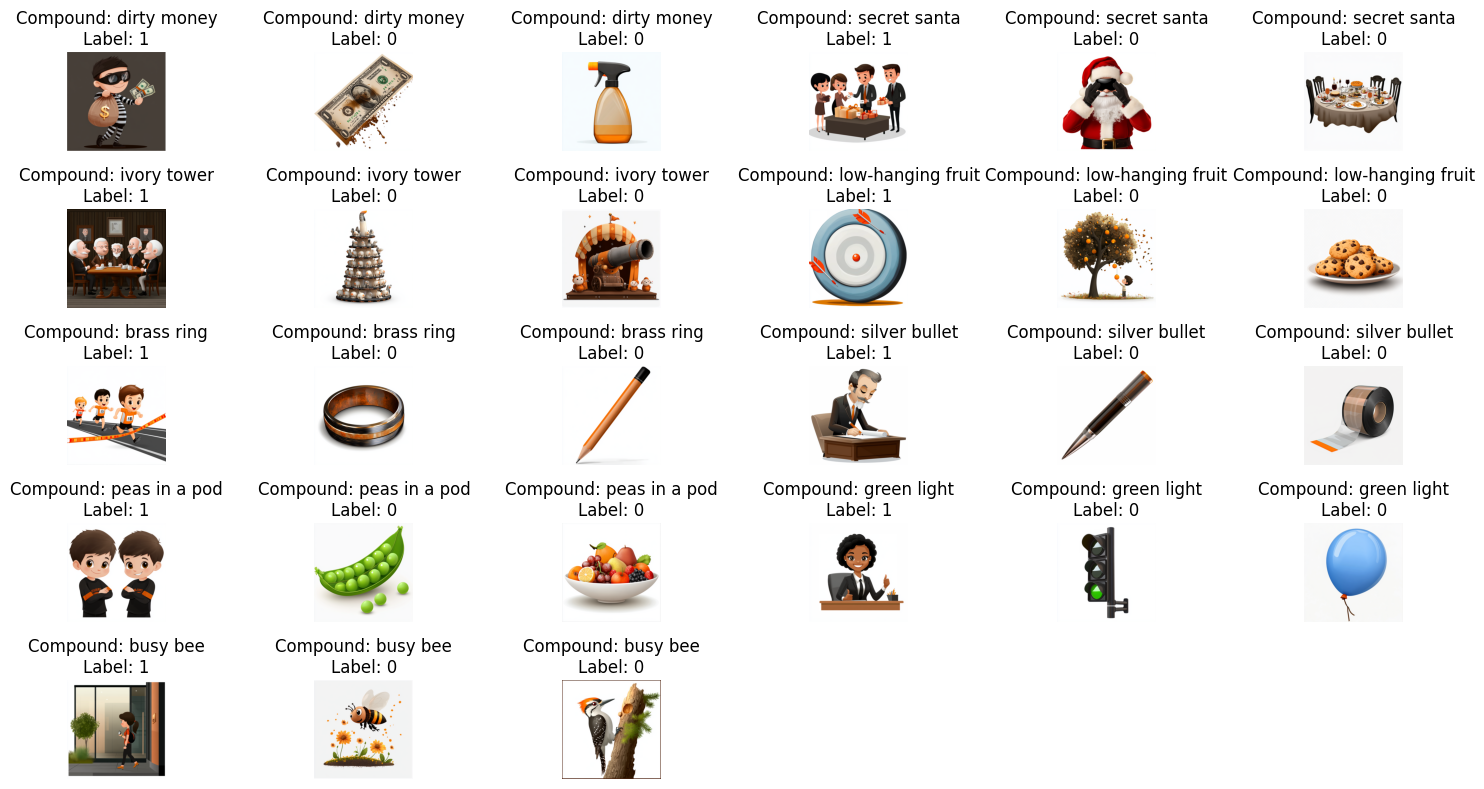

In [ ]:
# Visualise dataset. Note please don't try to visualize the whole training set, as there are many images.
image_folder = fpath+"test/images"

def visualise_data(df, image_folder):
    fig, axes = plt.subplots(len(df)//6+1, 6, figsize=(15, 8))
    axes = axes.flatten()

    for idx, row in df.iterrows():
        image_path = os.path.join(image_folder, row['image_name'])
        try:
            img = Image.open(image_path)
            ax = axes[idx]
            ax.imshow(img)
            ax.set_title(f"Compound: {row['compound']}\nLabel: {row['label']}")
            ax.axis('off')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")

    # Hide any empty subplots (those beyond the dataset size)
    for idx in range(len(df), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

visualise_data(test_df, fpath+"test/images")

# Step 1: NLP Exploratory Data Analysis

In [ ]:
# Dataset shape
print("Train Shape:", train_df.shape)
print("Validation Shape:", val_df.shape)
print("Test Shape:", test_df.shape)

Train Shape: (231, 6)
Validation Shape: (27, 6)
Test Shape: (27, 6)


In [ ]:
# Display sample data
train_df.head()

compound sentence_type  \
0  hot potato     idiomatic   
1  hot potato     idiomatic   
2  hot potato     idiomatic   
3  act of god     idiomatic   
4  act of god     idiomatic   

                                            sentence       image_name  \
0  The pipeline is set to create a human rights d...  46916305307.png   
1  The pipeline is set to create a human rights d...  00316911039.png   
2  The pipeline is set to create a human rights d...  71196374341.png   
3  Whether an event is intentional, accidental or...  80127117511.png   
4  Whether an event is intentional, accidental or...  51312988406.png   

                                       image_caption  label  
0  The image depicts two cartoon-style characters...      1  
1  The image depicts an oven with a large potato ...      0  
2  The image depicts an old, rolled-up parchment ...      0  
3  The image depicts a scene where a large tree h...      1  
4  The image depicts a whimsical scene featuring ...      0

In [ ]:
# Check missing value
print("Missing Values:\n", train_df.isnull().sum())

Missing Values:
 compound         0
sentence_type    0
sentence         0
image_name       0
image_caption    0
label            0
dtype: int64


In [ ]:
# Check balance of label
print("Label Distribution:\n", train_df['label'].value_counts())

Label Distribution:
 label
0    154
1     77
Name: count, dtype: int64


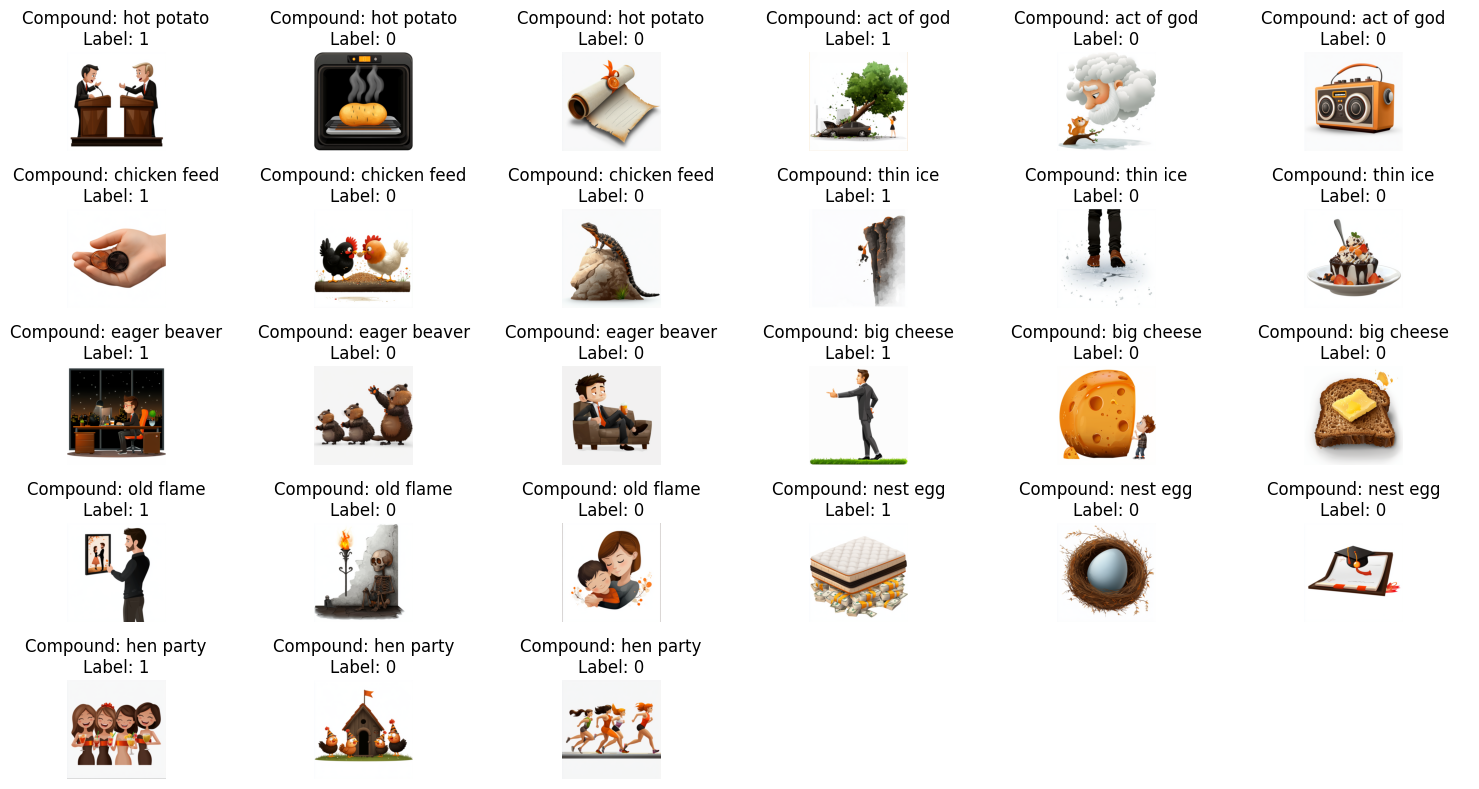

In [ ]:
# Visualization of train dataset
visualise_data(train_df.iloc[0:27], fpath+"train/images")

### Context

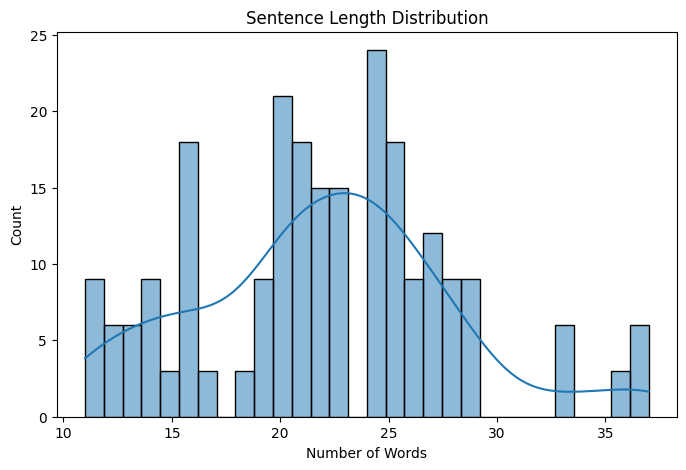

In [ ]:
# Explore sentence length distribution
train_df['sentence_length'] = train_df['sentence'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,5))
sns.histplot(train_df['sentence_length'], bins=30, kde=True)
plt.title("Sentence Length Distribution")
plt.xlabel("Number of Words")
plt.show()

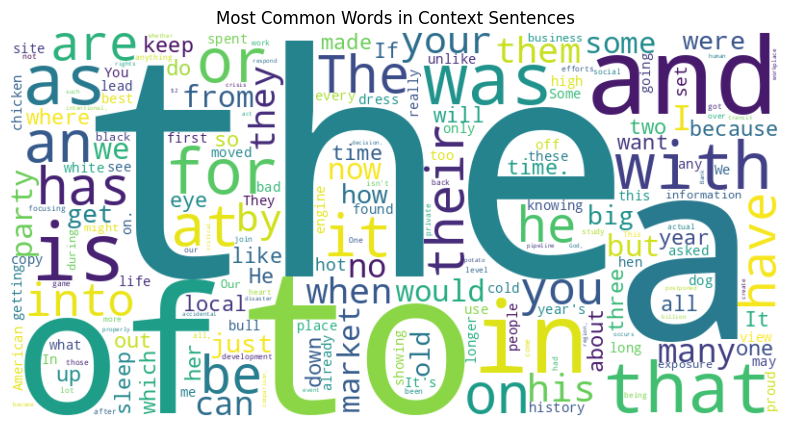

In [ ]:
# Explore the common words
text = " ".join(train_df['sentence'])
word_freq = Counter(text.split())

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Context Sentences")
plt.show()

### Image Caption

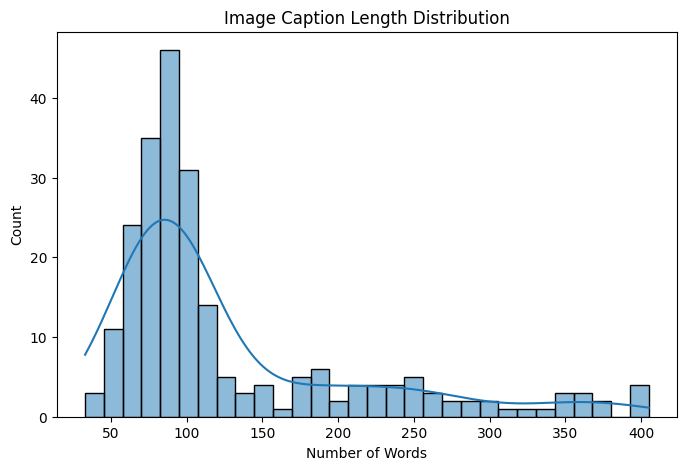

In [ ]:
# Explore sentence length distribution
train_df['image_caption_length'] = train_df['image_caption'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
sns.histplot(train_df['image_caption_length'], bins=30, kde=True)
plt.title("Image Caption Length Distribution")
plt.xlabel("Number of Words")
plt.show()

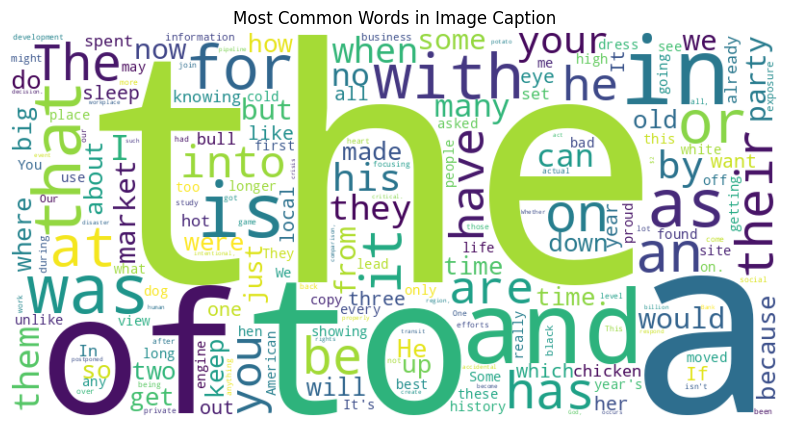

In [ ]:
# Explore the common words
text = " ".join(train_df['sentence'])
word_freq = Counter(text.split())

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Image Caption")
plt.show()

#Step 2: LLM based Data Augmentation

## 2.1 Data Augmentation (Imbalance)

In [ ]:
# Copy the train dataframe
train_augmented_df = train_df.copy()
train_augmented_df.head()

compound sentence_type  \
0  hot potato     idiomatic   
1  hot potato     idiomatic   
2  hot potato     idiomatic   
3  act of god     idiomatic   
4  act of god     idiomatic   

                                            sentence       image_name  \
0  The pipeline is set to create a human rights d...  46916305307.png   
1  The pipeline is set to create a human rights d...  00316911039.png   
2  The pipeline is set to create a human rights d...  71196374341.png   
3  Whether an event is intentional, accidental or...  80127117511.png   
4  Whether an event is intentional, accidental or...  51312988406.png   

                                       image_caption  label  sentence_length  \
0  The image depicts two cartoon-style characters...      1               27   
1  The image depicts an oven with a large potato ...      0               27   
2  The image depicts an old, rolled-up parchment ...      0               27   
3  The image depicts a scene where a large tree h...      1               25   
4  The image depicts a whimsical scene featuring ...      0               25   

   image_caption_length  
0                    97  
1                    98  
2                    62  
3                   100  
4                   110

### 2.1.1 Apply NER and replace named entities

In [ ]:
def sentence_entities_conversion(text):
    # Process the text to extract entities
    doc = nlp(text)

    # Create a dictionary of entities and their corresponding placeholders
    entities = {ent.text: f"[{ent.label_}]" for ent in doc.ents}

    # Mask the entities by replacing them with their respective placeholders
    masked_text = text
    for entity, placeholder in entities.items():
        masked_text = masked_text.replace(entity, placeholder)

    return masked_text, entities

#### Sentence NER

In [ ]:
# Load the pre-trained English NER model
nlp = spacy.load("en_core_web_sm")

# Apply the conversion function to each sentence and create two columns in the DataFrame
train_augmented_df[['sentence_entities', 'entities']] = train_augmented_df['sentence'].apply(lambda x: pd.Series(sentence_entities_conversion(x)))

# Display the updated DataFrame
train_augmented_df[['sentence_entities', 'entities']].head()

sentence_entities           entities
0  The pipeline is set to create a human rights d...  {'Bank': '[ORG]'}
1  The pipeline is set to create a human rights d...  {'Bank': '[ORG]'}
2  The pipeline is set to create a human rights d...  {'Bank': '[ORG]'}
3  Whether an event is intentional, accidental or...                 {}
4  Whether an event is intentional, accidental or...                 {}

#### Image caption NER

In [ ]:
# Load the pre-trained English NER model
nlp = spacy.load("en_core_web_sm")

# Apply the conversion function to each sentence and create two columns in the DataFrame
train_augmented_df[['image_caption_entities', 'caption_entities']] = train_augmented_df['image_caption'].apply(lambda x: pd.Series(sentence_entities_conversion(x)))

# Display the updated DataFrame
train_augmented_df[['image_caption_entities', 'caption_entities']].head()

image_caption_entities       caption_entities
0  The image depicts [CARDINAL] cartoon-style cha...  {'two': '[CARDINAL]'}
1  The image depicts an oven with a large potato ...                     {}
2  The image depicts an old, rolled-up parchment ...                     {}
3  The image depicts a scene where a large tree h...                     {}
4  The image depicts a whimsical scene featuring ...                     {}

### 2.1.2 Paraphasing using Hugging Face's T5 model

In [ ]:
# Load Hugging Face's T5 model for paraphrasing
model_name = "ramsrigouthamg/t5_paraphraser"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

In [ ]:
def paraphrasing_text(text, num_return_sequences=3, max_length=128):

    # Create prompt for pre-trained model
    input_text = f"paraphrase: {text}"

    # Convert the text into numerical tokens
    encoding = tokenizer.encode_plus(input_text, return_tensors="pt", max_length=max_length, truncation=True)

    # Generate paraphrased outputs
    with torch.no_grad():
        outputs = model.generate(
            input_ids=encoding["input_ids"],
            attention_mask=encoding["attention_mask"],
            max_length=max_length,
            num_return_sequences=num_return_sequences,
            temperature=1.0,
            top_k=50,
            top_p=0.98,
            do_sample=True
        )

    # Decode generated texts
    paraphrased_text = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

    return paraphrased_text

#### Augmented sentence

In [ ]:
original_sentence = train_augmented_df['sentence_entities'].unique()
augmented_df = pd.DataFrame()

for sentence in tqdm(original_sentence, desc="Paraphrasing Sentences", unit="sentence"):
    paraphrased_text = paraphrasing_text(sentence, num_return_sequences=2)

    # Create a temporary DataFrame and append it to the main DataFrame
    temp_df = pd.DataFrame({
        'sentence_entities': [sentence] * (len(paraphrased_text) + 1),
        'paraphrased_sentence': paraphrased_text + [sentence]
    })

    augmented_df = pd.concat([augmented_df, temp_df], ignore_index=True)

Paraphrasing Sentences: 100%|██████████| 77/77 [04:10<00:00,  3.26s/sentence]


In [ ]:
augmented_df.head()

sentence_entities  \
0  The pipeline is set to create a human rights d...   
1  The pipeline is set to create a human rights d...   
2  The pipeline is set to create a human rights d...   
3  Whether an event is intentional, accidental or...   
4  Whether an event is intentional, accidental or...   

                                paraphrased_sentence  
0  The pipeline is set to create a human rights d...  
1  Will the pipeline create a humanitarian disast...  
2  The pipeline is set to create a human rights d...  
3  When someone has a crisis at work, whether it'...  
4  How do I respond in a crisis at the workplace ...

#### Augmented image caption

In [ ]:
original_sentence = train_augmented_df['image_caption_entities'].unique()
augmented_caption_df = pd.DataFrame()

# Wrap the loop with tqdm to track progress
for sentence in tqdm(original_sentence, desc="Paraphrasing Sentences", unit="sentence"):
    paraphrased_text = paraphrasing_text(sentence, num_return_sequences=2)

    # Create a temporary DataFrame and append it to the main DataFrame
    temp_df = pd.DataFrame({
        'image_caption_entities': [sentence] * (len(paraphrased_text) + 1),
        'paraphrased_caption': paraphrased_text + [sentence]
    })

    augmented_caption_df = pd.concat([augmented_caption_df, temp_df], ignore_index=True)

Paraphrasing Sentences: 100%|██████████| 231/231 [30:54<00:00,  8.03s/sentence]


In [ ]:
augmented_caption_df

image_caption_entities  \
0    The image depicts [CARDINAL] cartoon-style cha...   
1    The image depicts [CARDINAL] cartoon-style cha...   
2    The image depicts [CARDINAL] cartoon-style cha...   
3    The image depicts an oven with a large potato ...   
4    The image depicts an oven with a large potato ...   
..                                                 ...   
688  The image depicts a vibrant and lively scene o...   
689  The image depicts a vibrant and lively scene o...   
690  The image depicts a small, quaint church with ...   
691  The image depicts a small, quaint church with ...   
692  The image depicts a small, quaint church with ...   

                                   paraphrased_caption  
0    In this video, a character is sitting behind p...  
1    The image depicts [CARDINAL] cartoon-style cha...  
2    The image depicts [CARDINAL] cartoon-style cha...  
3    The image depicts an oven with a large potato ...  
4    The image depicts an oven with a large potato ...  
..                                                 ...  
688  The image depicts a vibrant and lively scene o...  
689  The image depicts a vibrant and lively scene o...  
690  The image depicts a small, quaint church with ...  
691  The image depicts a small, quaint church with ...  
692  The image depicts a small, quaint church with ...  

[693 rows x 2 columns]

#### Merge into one dataframe

In [ ]:
train_augmented_df = train_augmented_df.merge(augmented_df, on="sentence_entities", how="left")
train_augmented_df.head()

compound sentence_type  \
0  hot potato     idiomatic   
1  hot potato     idiomatic   
2  hot potato     idiomatic   
3  hot potato     idiomatic   
4  hot potato     idiomatic   

                                            sentence       image_name  \
0  The pipeline is set to create a human rights d...  46916305307.png   
1  The pipeline is set to create a human rights d...  46916305307.png   
2  The pipeline is set to create a human rights d...  46916305307.png   
3  The pipeline is set to create a human rights d...  00316911039.png   
4  The pipeline is set to create a human rights d...  00316911039.png   

                                       image_caption  label  sentence_length  \
0  The image depicts two cartoon-style characters...      1               27   
1  The image depicts two cartoon-style characters...      1               27   
2  The image depicts two cartoon-style characters...      1               27   
3  The image depicts an oven with a large potato ...      0               27   
4  The image depicts an oven with a large potato ...      0               27   

   image_caption_length                                  sentence_entities  \
0                    97  The pipeline is set to create a human rights d...   
1                    97  The pipeline is set to create a human rights d...   
2                    97  The pipeline is set to create a human rights d...   
3                    98  The pipeline is set to create a human rights d...   
4                    98  The pipeline is set to create a human rights d...   

            entities                             image_caption_entities  \
0  {'Bank': '[ORG]'}  The image depicts [CARDINAL] cartoon-style cha...   
1  {'Bank': '[ORG]'}  The image depicts [CARDINAL] cartoon-style cha...   
2  {'Bank': '[ORG]'}  The image depicts [CARDINAL] cartoon-style cha...   
3  {'Bank': '[ORG]'}  The image depicts an oven with a large potato ...   
4  {'Bank': '[ORG]'}  The image depicts an oven with a large potato ...   

        caption_entities                               paraphrased_sentence  
0  {'two': '[CARDINAL]'}  The pipeline is set to create a human rights d...  
1  {'two': '[CARDINAL]'}  Will the pipeline create a humanitarian disast...  
2  {'two': '[CARDINAL]'}  The pipeline is set to create a human rights d...  
3                     {}  The pipeline is set to create a human rights d...  
4                     {}  Will the pipeline create a humanitarian disast...

In [ ]:
train_augmented_df.shape

(693, 13)

In [ ]:
train_augmented_df = train_augmented_df.merge(augmented_caption_df, on="image_caption_entities", how="left")
train_augmented_df.head()

compound sentence_type  \
0  hot potato     idiomatic   
1  hot potato     idiomatic   
2  hot potato     idiomatic   
3  hot potato     idiomatic   
4  hot potato     idiomatic   

                                            sentence       image_name  \
0  The pipeline is set to create a human rights d...  46916305307.png   
1  The pipeline is set to create a human rights d...  46916305307.png   
2  The pipeline is set to create a human rights d...  46916305307.png   
3  The pipeline is set to create a human rights d...  46916305307.png   
4  The pipeline is set to create a human rights d...  46916305307.png   

                                       image_caption  label  sentence_length  \
0  The image depicts two cartoon-style characters...      1               27   
1  The image depicts two cartoon-style characters...      1               27   
2  The image depicts two cartoon-style characters...      1               27   
3  The image depicts two cartoon-style characters...      1               27   
4  The image depicts two cartoon-style characters...      1               27   

   image_caption_length                                  sentence_entities  \
0                    97  The pipeline is set to create a human rights d...   
1                    97  The pipeline is set to create a human rights d...   
2                    97  The pipeline is set to create a human rights d...   
3                    97  The pipeline is set to create a human rights d...   
4                    97  The pipeline is set to create a human rights d...   

            entities                             image_caption_entities  \
0  {'Bank': '[ORG]'}  The image depicts [CARDINAL] cartoon-style cha...   
1  {'Bank': '[ORG]'}  The image depicts [CARDINAL] cartoon-style cha...   
2  {'Bank': '[ORG]'}  The image depicts [CARDINAL] cartoon-style cha...   
3  {'Bank': '[ORG]'}  The image depicts [CARDINAL] cartoon-style cha...   
4  {'Bank': '[ORG]'}  The image depicts [CARDINAL] cartoon-style cha...   

        caption_entities                               paraphrased_sentence  \
0  {'two': '[CARDINAL]'}  The pipeline is set to create a human rights d...   
1  {'two': '[CARDINAL]'}  The pipeline is set to create a human rights d...   
2  {'two': '[CARDINAL]'}  The pipeline is set to create a human rights d...   
3  {'two': '[CARDINAL]'}  Will the pipeline create a humanitarian disast...   
4  {'two': '[CARDINAL]'}  Will the pipeline create a humanitarian disast...   

                                 paraphrased_caption  
0  In this video, a character is sitting behind p...  
1  The image depicts [CARDINAL] cartoon-style cha...  
2  The image depicts [CARDINAL] cartoon-style cha...  
3  In this video, a character is sitting behind p...  
4  The image depicts [CARDINAL] cartoon-style cha...

In [ ]:
train_augmented_df.shape

(2079, 14)

### 2.1.3 Convert NER back to original entities

In [ ]:
def restore_named_entities(paraphrased_text, entity_map):
    for entity, placeholder in entity_map.items():
        paraphrased_text = paraphrased_text.replace(placeholder, entity)
    return paraphrased_text

In [ ]:
train_augmented_df['augmented_sentence'] = train_augmented_df.apply(lambda x: restore_named_entities(x['paraphrased_sentence'], x['entities']), axis=1)
train_augmented_df['augmented_caption'] = train_augmented_df.apply(lambda x: restore_named_entities(x['paraphrased_caption'], x['caption_entities']), axis=1)

train_augmented_df

compound sentence_type  \
0        hot potato     idiomatic   
1        hot potato     idiomatic   
2        hot potato     idiomatic   
3        hot potato     idiomatic   
4        hot potato     idiomatic   
...             ...           ...   
2074  watering hole     idiomatic   
2075  watering hole     idiomatic   
2076  watering hole     idiomatic   
2077  watering hole     idiomatic   
2078  watering hole     idiomatic   

                                               sentence       image_name  \
0     The pipeline is set to create a human rights d...  46916305307.png   
1     The pipeline is set to create a human rights d...  46916305307.png   
2     The pipeline is set to create a human rights d...  46916305307.png   
3     The pipeline is set to create a human rights d...  46916305307.png   
4     The pipeline is set to create a human rights d...  46916305307.png   
...                                                 ...              ...   
2074  If you want to feel like an actual pirate, the...  10734342674.png   
2075  If you want to feel like an actual pirate, the...  10734342674.png   
2076  If you want to feel like an actual pirate, the...  10734342674.png   
2077  If you want to feel like an actual pirate, the...  10734342674.png   
2078  If you want to feel like an actual pirate, the...  10734342674.png   

                                          image_caption  label  \
0     The image depicts two cartoon-style characters...      1   
1     The image depicts two cartoon-style characters...      1   
2     The image depicts two cartoon-style characters...      1   
3     The image depicts two cartoon-style characters...      1   
4     The image depicts two cartoon-style characters...      1   
...                                                 ...    ...   
2074  The image depicts a small, quaint church with ...      0   
2075  The image depicts a small, quaint church with ...      0   
2076  The image depicts a small, quaint church with ...      0   
2077  The image depicts a small, quaint church with ...      0   
2078  The image depicts a small, quaint church with ...      0   

      sentence_length  image_caption_length  \
0                  27                    97   
1                  27                    97   
2                  27                    97   
3                  27                    97   
4                  27                    97   
...               ...                   ...   
2074               37                   218   
2075               37                   218   
2076               37                   218   
2077               37                   218   
2078               37                   218   

                                      sentence_entities  \
0     The pipeline is set to create a human rights d...   
1     The pipeline is set to create a human rights d...   
2     The pipeline is set to create a human rights d...   
3     The pipeline is set to create a human rights d...   
4     The pipeline is set to create a human rights d...   
...                                                 ...   
2074  If you want to feel like an actual pirate, the...   
2075  If you want to feel like an actual pirate, the...   
2076  If you want to feel like an actual pirate, the...   
2077  If you want to feel like an actual pirate, the...   
2078  If you want to feel like an actual pirate, the...   

                     entities  \
0           {'Bank': '[ORG]'}   
1           {'Bank': '[ORG]'}   
2           {'Bank': '[ORG]'}   
3           {'Bank': '[ORG]'}   
4           {'Bank': '[ORG]'}   
...                       ...   
2074  {'all night': '[TIME]'}   
2075  {'all night': '[TIME]'}   
2076  {'all night': '[TIME]'}   
2077  {'all night': '[TIME]'}   
2078  {'all night': '[TIME]'}   

                                 image_caption_entities  \
0     The image depicts [CARDINAL] cartoon-style cha...   
1     The image depicts [CARDINAL] cartoon-style cha...   
2     The im

In [ ]:
# Save file
# train_augmented_df.to_csv("/content/drive/MyDrive/CSC8645_Chatwipa/TASK 2/dataset/imbalanced_train_augmented.csv", index=False)

In [ ]:
# Check balance of label
print("Label Distribution:\n", train_augmented_df['label'].value_counts())

Label Distribution:
 label
0    1386
1     693
Name: count, dtype: int64


## 2.2 Data Augmentation (Balance)

In [ ]:
# Separate the two classes
label0_df = train_augmented_df[train_augmented_df['label'] == 0]
label1_df = train_augmented_df[train_augmented_df['label'] == 1]

# Randomly downsampling
label0_df = label0_df.sample(n=len(label1_df), random_state=42)

# Concatenate both classes back together
df_balanced = pd.concat([label0_df, label1_df])

# Check balance of label
print("Label Distribution:\n", df_balanced['label'].value_counts())

Label Distribution:
 label
0    693
1    693
Name: count, dtype: int64


In [ ]:
# Save file
# df_balanced.to_csv("/content/drive/MyDrive/CSC8645_Chatwipa/TASK 2/dataset/balanced_train_augmented.csv", index=False)

# Step 3: Zero-shot prediction


#### 3.1 Data preparation

In [ ]:
# Preparing dataset
test_image_folder = "/content/dataset/test/images"
df = pd.read_csv("/content/dataset/test/test.csv")
df.head()

compound sentence_type  \
0   dirty money     idiomatic   
1   dirty money     idiomatic   
2   dirty money     idiomatic   
3  secret santa     idiomatic   
4  secret santa     idiomatic   

                                            sentence       image_name  \
0  When dirty money disappears offshore, it becom...  08230960409.png   
1  When dirty money disappears offshore, it becom...  46913780614.png   
2  When dirty money disappears offshore, it becom...  58491774071.png   
3  She got very annoyed when some wag got her a p...  12319434549.png   
4  She got very annoyed when some wag got her a p...  05850548023.png   

                                       image_caption  label  
0  The image depicts a cartoon character dressed ...      1  
1  The image depicts a one-dollar bill with the p...      0  
2  The image depicts a spray bottle, commonly use...      0  
3  The image depicts a group of four people, two ...      1  
4  The image depicts a person dressed in a Santa ...      0

### 3.2 Model preparation

In [ ]:
# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [ ]:
def predict_best_image(compound, context, image_names, captions, image_folder):

    # Tokenizing the Text Input
    text_inputs = clip.tokenize([f"{compound}: {context}"]).to(device)

    # Text encoding
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)

    # Processing Each Image
    similarities = []
    for img_name, caption in zip(image_names, captions):
        image_path = f"{image_folder}/{img_name}"
        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

        # Image encoding
        with torch.no_grad():
            image_features = model.encode_image(image)

        # Compute text-to-image similarity
        similarity_img = torch.nn.functional.cosine_similarity(text_features, image_features).item()

        # Encode Caption
        caption_input = clip.tokenize([caption], truncate=True).to(device)
        with torch.no_grad():
            caption_features = model.encode_text(caption_input)

        # Compute text-to-caption similarity
        similarity_caption = torch.nn.functional.cosine_similarity(text_features, caption_features).item()

        # Total similarity score
        total_similarity = (similarity_img + similarity_caption)/2
        similarities.append(total_similarity)

    best_match_idx = similarities.index(max(similarities))
    return image_names[best_match_idx]

### 3.3 Model evaluation

In [ ]:
def evaluate(df):
    metrics = {
        "accuracy": accuracy_score(df["label"], df["prediction"]),
        "precision": precision_score(df["label"], df["prediction"]),
        "recall": recall_score(df["label"], df["prediction"]),
        "f1_score": f1_score(df["label"], df["prediction"])
    }
    return metrics

def visualize_predictions(df, image_folder):

  compound = df['compound'].unique()
  num_samples = len(compound)
  sample_df = df[df['compound'].isin(compound)]

  # Create figure for visualization
  fig, axes = plt.subplots(num_samples, 3, figsize=(5, 2 * num_samples))

  for i, comp in enumerate(compound):
      # Ground Truth Image
      ground_truth_img = sample_df[(sample_df['compound'] == compound[i])&(sample_df['label'] == 1)]['image_name'].iloc[0]
      ground_truth_img_path = os.path.join(test_image_folder, ground_truth_img)
      ground_truth = Image.open(ground_truth_img_path)

      # Predicted Image
      predicted_img = sample_df[(sample_df['compound'] == compound[i])&(sample_df['prediction'] == 1)]['image_name'].iloc[0]
      predicted_img_path = os.path.join(test_image_folder, predicted_img)
      predicted = Image.open(predicted_img_path)

      # Display Compound (Text)
      axes[i][0].text(0.5, 0.5, comp, fontsize=12, ha='center', va='center')
      axes[i][0].axis("off")

      # Display Ground Truth Image
      axes[i][1].imshow(ground_truth)
      axes[i][1].set_title("Ground Truth Image")
      axes[i][1].axis("off")

      # Display Predicted Image
      axes[i][2].imshow(predicted)
      axes[i][2].set_title("Predicted Image")
      axes[i][2].axis("off")

  plt.tight_layout()
  plt.show()

In [ ]:
predictions = []

for _, group in tqdm(df.groupby(["compound", "sentence"])):
    # Get the sentence and image path
    compound = group["compound"].iloc[0]
    context = group["sentence"].iloc[0]
    image_names = group["image_name"].tolist()
    captions = group["image_caption"].tolist()

    # Predict the best image
    best_image = predict_best_image(compound, context, image_names, captions, test_image_folder)

    # Assign 1 if the predicted image matches the actual correct image, otherwise 0
    predicted_label = (group["image_name"] == best_image).astype(int).tolist()
    predictions.extend(predicted_label)  # Append to the predictions list

# Add predictions as a new column
df["prediction"] = predictions

100%|██████████| 9/9 [00:01<00:00,  5.91it/s]


In [ ]:
evaluate_result = evaluate(df)
print(evaluate_result)

{'accuracy': 0.4074074074074074, 'precision': 0.1111111111111111, 'recall': 0.1111111111111111, 'f1_score': 0.1111111111111111}


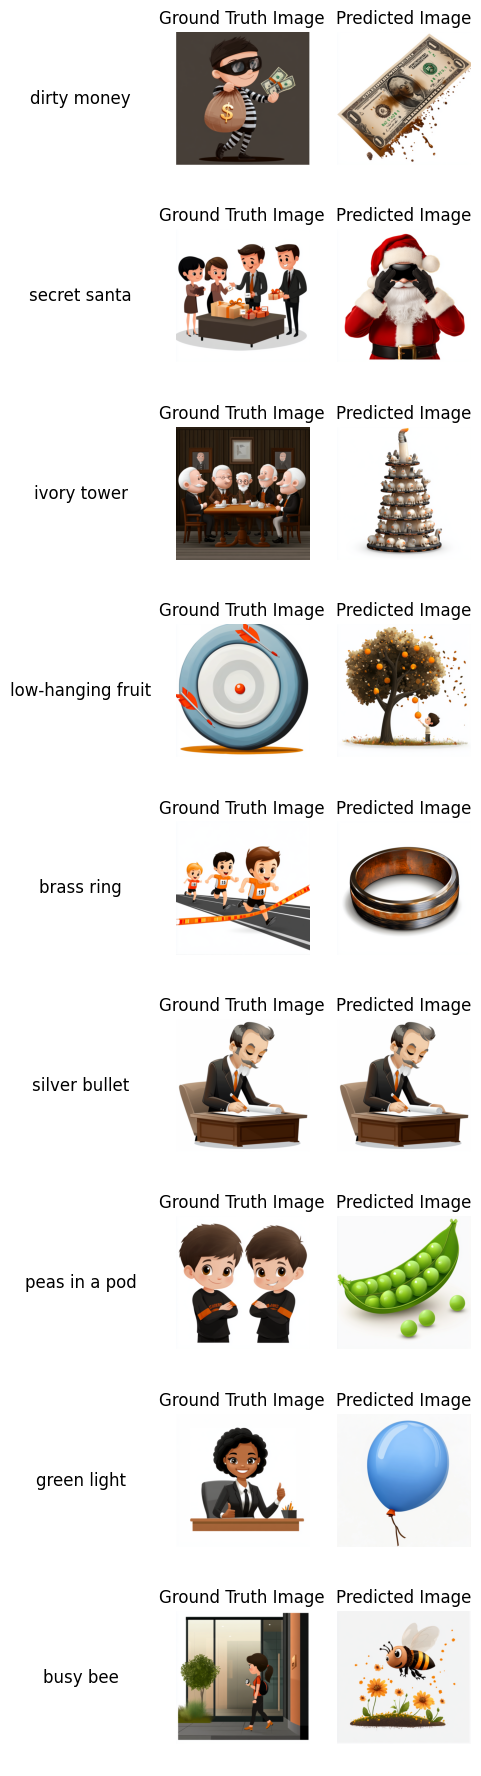

In [ ]:
visualize_predictions(df, test_image_folder)

# Step 4: Fine-tuning based and other prediction approaches

### 4.1 CLIP model fine-tuning with original

#### 4.1.1 Load CLIP model

In [ ]:
class CLIPFineTuner(nn.Module):
    def __init__(self, model, num_classes):
        super(CLIPFineTuner, self).__init__()
        self.model = model

        # Linear layers to project image and text embeddings into a common space
        self.image_proj = nn.Linear(model.visual.output_dim, 512)  # Project image features
        self.text_proj = nn.Linear(model.text_projection.shape[0], 512)  # Project text features

        # Classifier to predict the label based on concatenated features
        self.classifier = nn.Linear(512 * 3, num_classes)  # Concatenating image, idiom, and caption features

    def forward(self, image, idiom_tokens, caption_tokens):
        # Encode image features
        with torch.no_grad():
            image_features = self.model.encode_image(image).float()

        # Encode idiom and caption
        with torch.no_grad():
            idiom_features = self.model.encode_text(idiom_tokens).float()
            caption_features = self.model.encode_text(caption_tokens).float()

        # Project features into a common space
        image_features = self.image_proj(image_features)
        idiom_features = self.text_proj(idiom_features)
        caption_features = self.text_proj(caption_features)

        # Concatenate features
        combined_features = torch.cat([image_features, idiom_features, caption_features], dim=1)

        # Pass through classifier
        return self.classifier(combined_features)

In [ ]:
# OpenAI CLIP model and preprocessing
model, preprocess = clip.load("ViT-B/32", jit=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [ ]:
num_classes = 2  # Binary classification
model_ft = CLIPFineTuner(model, num_classes).to(device)

#### 4.1.2 Preprocessing the dataset

In [ ]:
class IdiomDataset(Dataset):
    def __init__(self, df, image_folder):
        self.df = df
        self.image_folder = image_folder
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # CLIP expects 224x224 images
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                                 (0.26862954, 0.26130258, 0.27577711))
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load and preprocess image
        image_path = f"{self.image_folder}/{row['image_name']}"
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)  # Apply transformations

        # Tokenize conpound + context
        idiom_text = f"{row['compound']}: {row['sentence']}"
        tokenized_idiom = clip.tokenize([idiom_text])[0]

        # Tokenize caption with truncation
        caption_text = row["image_caption"]
        tokenized_caption = clip.tokenize([caption_text], truncate=True)[0]

        # Convert label to tensor
        label = torch.tensor(row["label"], dtype=torch.long)

        return image, tokenized_idiom, tokenized_caption, label

In [ ]:
# Load dataset
original_df = train_df.copy()
val_df = pd.read_csv("/content/dataset/val/val.csv")

# Create train and validation datasets
train_dataset = IdiomDataset(original_df, image_folder ="/content/dataset/train/images")
val_dataset = IdiomDataset(val_df, image_folder ="/content/dataset/val/images")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

#### 4.1.3 Define loss and optimizer

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.classifier.parameters(), lr=1e-4)

#### 4.1.4 Fine-Tuning CLIP Model

In [ ]:
save_path = "/content/drive/MyDrive/CSC8645_Chatwipa/TASK 2/model"
date = datetime.today().strftime('%Y-%m-%d')

In [ ]:
# Number of epochs for training
num_epochs = 10
previous_acc = 0

for epoch in range(num_epochs):
    model_ft.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss for the current epoch
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")  # Initialize progress bar

    # Training
    for images, idioms, captions, labels in pbar:
        images, idioms, captions, labels = images.to(device), idioms.to(device), captions.to(device), labels.to(device)

        # Clear previous gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model_ft(images, idioms, captions)

        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters
        running_loss += loss.item()  # Track loss
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')  # Print avg loss

    # Validation
    model_ft.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, idioms, captions, labels in val_loader:
            images, idioms, captions, labels = images.to(device), idioms.to(device), captions.to(device), labels.to(device)

            outputs = model_ft(images, idioms, captions)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f'Validation Accuracy: {val_accuracy:.2f}%')

    # Save model if highest accuracy
    if val_accuracy >= previous_acc:
        previous_acc = val_accuracy
        torch.save(model_ft.state_dict(), f'{save_path}/original_clip_finetuned_{date}.pth')
        print("Model saved!")

Epoch 1/10, Loss: 0.6523: 100%|██████████| 15/15 [00:08<00:00,  1.67it/s]


Epoch [1/10], Loss: 0.6523
Validation Accuracy: 66.67%
Model saved!


Epoch 2/10, Loss: 0.6152: 100%|██████████| 15/15 [00:08<00:00,  1.69it/s]


Epoch [2/10], Loss: 0.6152
Validation Accuracy: 66.67%
Model saved!


Epoch 3/10, Loss: 0.6171: 100%|██████████| 15/15 [00:08<00:00,  1.70it/s]


Epoch [3/10], Loss: 0.6171
Validation Accuracy: 66.67%
Model saved!


Epoch 4/10, Loss: 0.6055: 100%|██████████| 15/15 [00:08<00:00,  1.87it/s]


Epoch [4/10], Loss: 0.6055
Validation Accuracy: 66.67%
Model saved!


Epoch 5/10, Loss: 0.5897: 100%|██████████| 15/15 [00:08<00:00,  1.86it/s]


Epoch [5/10], Loss: 0.5897
Validation Accuracy: 66.67%
Model saved!


Epoch 6/10, Loss: 0.5775: 100%|██████████| 15/15 [00:08<00:00,  1.70it/s]


Epoch [6/10], Loss: 0.5775
Validation Accuracy: 66.67%
Model saved!


Epoch 7/10, Loss: 0.5689: 100%|██████████| 15/15 [00:08<00:00,  1.69it/s]


Epoch [7/10], Loss: 0.5689
Validation Accuracy: 66.67%
Model saved!


Epoch 8/10, Loss: 0.5605: 100%|██████████| 15/15 [00:08<00:00,  1.68it/s]


Epoch [8/10], Loss: 0.5605
Validation Accuracy: 66.67%
Model saved!


Epoch 9/10, Loss: 0.5499: 100%|██████████| 15/15 [00:08<00:00,  1.68it/s]


Epoch [9/10], Loss: 0.5499
Validation Accuracy: 66.67%
Model saved!


Epoch 10/10, Loss: 0.5533: 100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


Epoch [10/10], Loss: 0.5533
Validation Accuracy: 66.67%
Model saved!


#### 4.1.5 Model evaluation

In [ ]:
def evaluate(df):
    metrics = {
        "accuracy": accuracy_score(df["label"], df["prediction"]),
        "precision": precision_score(df["label"], df["prediction"]),
        "recall": recall_score(df["label"], df["prediction"]),
        "f1_score": f1_score(df["label"], df["prediction"])
    }
    return metrics

def visualize_predictions(df, image_folder):

  compound = df['compound'].unique()
  num_samples = len(compound)
  sample_df = df[df['compound'].isin(compound)]

  # Create figure for visualization
  fig, axes = plt.subplots(num_samples, 3, figsize=(5, 2 * num_samples))

  for i, comp in enumerate(compound):
      # Ground Truth Image
      ground_truth_img = sample_df[(sample_df['compound'] == compound[i])&(sample_df['label'] == 1)]['image_name'].iloc[0]
      ground_truth_img_path = os.path.join(test_image_folder, ground_truth_img)
      ground_truth = Image.open(ground_truth_img_path)

      # Predicted Image
      predicted_img = sample_df[(sample_df['compound'] == compound[i])&(sample_df['prediction'] == 1)]['image_name'].iloc[0]
      predicted_img_path = os.path.join(test_image_folder, predicted_img)
      predicted = Image.open(predicted_img_path)

      # Display Compound (Text)
      axes[i][0].text(0.5, 0.5, comp, fontsize=12, ha='center', va='center')
      axes[i][0].axis("off")

      # Display Ground Truth Image
      axes[i][1].imshow(ground_truth)
      axes[i][1].set_title("Ground Truth Image")
      axes[i][1].axis("off")

      # Display Predicted Image
      axes[i][2].imshow(predicted)
      axes[i][2].set_title("Predicted Image")
      axes[i][2].axis("off")

  plt.tight_layout()
  plt.show()

def predict_best_image(model, compound, context, image_names, captions, image_folder, transform, device):
    model.eval()  # Set model to evaluation mode

    # Tokenizing the Text Input (Idiomatic Phrase + Context)
    idiom_text = clip.tokenize([f"{compound}: {context}"]).to(device)

    best_score = float('-inf')
    best_image = None

    # Processing Each Image
    for img_name, caption in zip(image_names, captions):
        image_path = f"{image_folder}/{img_name}"
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)  # Apply preprocessing

        # Tokenizing Caption
        caption_text = clip.tokenize([caption], truncate=True).to(device)

        with torch.no_grad():
            output = model(image, idiom_text, caption_text)  # Forward pass
            predicted_score = torch.softmax(output, dim=1)[:, 1].item()  # Probability of "correct" class

        # Track Best Image
        if predicted_score > best_score:
            best_score = predicted_score
            best_image = img_name

    return best_image  # Return the image with the highest "correct" probability

In [ ]:
# Preparing dataset
test_image_folder = "/content/dataset/test/images"
df = pd.read_csv("/content/dataset/test/test.csv")
df.head()

compound sentence_type  \
0   dirty money     idiomatic   
1   dirty money     idiomatic   
2   dirty money     idiomatic   
3  secret santa     idiomatic   
4  secret santa     idiomatic   

                                            sentence       image_name  \
0  When dirty money disappears offshore, it becom...  08230960409.png   
1  When dirty money disappears offshore, it becom...  46913780614.png   
2  When dirty money disappears offshore, it becom...  58491774071.png   
3  She got very annoyed when some wag got her a p...  12319434549.png   
4  She got very annoyed when some wag got her a p...  05850548023.png   

                                       image_caption  label  
0  The image depicts a cartoon character dressed ...      1  
1  The image depicts a one-dollar bill with the p...      0  
2  The image depicts a spray bottle, commonly use...      0  
3  The image depicts a group of four people, two ...      1  
4  The image depicts a person dressed in a Santa ...      0

In [ ]:
predictions = []

for _, group in tqdm(df.groupby(["compound", "sentence"])):
    # Get the sentence and image path
    compound = group["compound"].iloc[0]
    context = group["sentence"].iloc[0]
    image_names = group["image_name"].tolist()
    captions = group["image_caption"].tolist()

    # Predict the best image
    best_image = predict_best_image(model_ft, compound, context, image_names, captions, test_image_folder,
                                        transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                             (0.26862954, 0.26130258, 0.27577711))
    ]),
    device=device)

    # Assign 1 if the predicted image matches the actual correct image, otherwise 0
    predicted_label = (group["image_name"] == best_image).astype(int).tolist()
    predictions.extend(predicted_label)  # Append to the predictions list

# Add predictions as a new column
df["prediction"] = predictions

100%|██████████| 9/9 [00:01<00:00,  5.70it/s]


In [ ]:
evaluate_result = evaluate(df)
print(evaluate_result)

{'accuracy': 0.9259259259259259, 'precision': 0.8888888888888888, 'recall': 0.8888888888888888, 'f1_score': 0.8888888888888888}


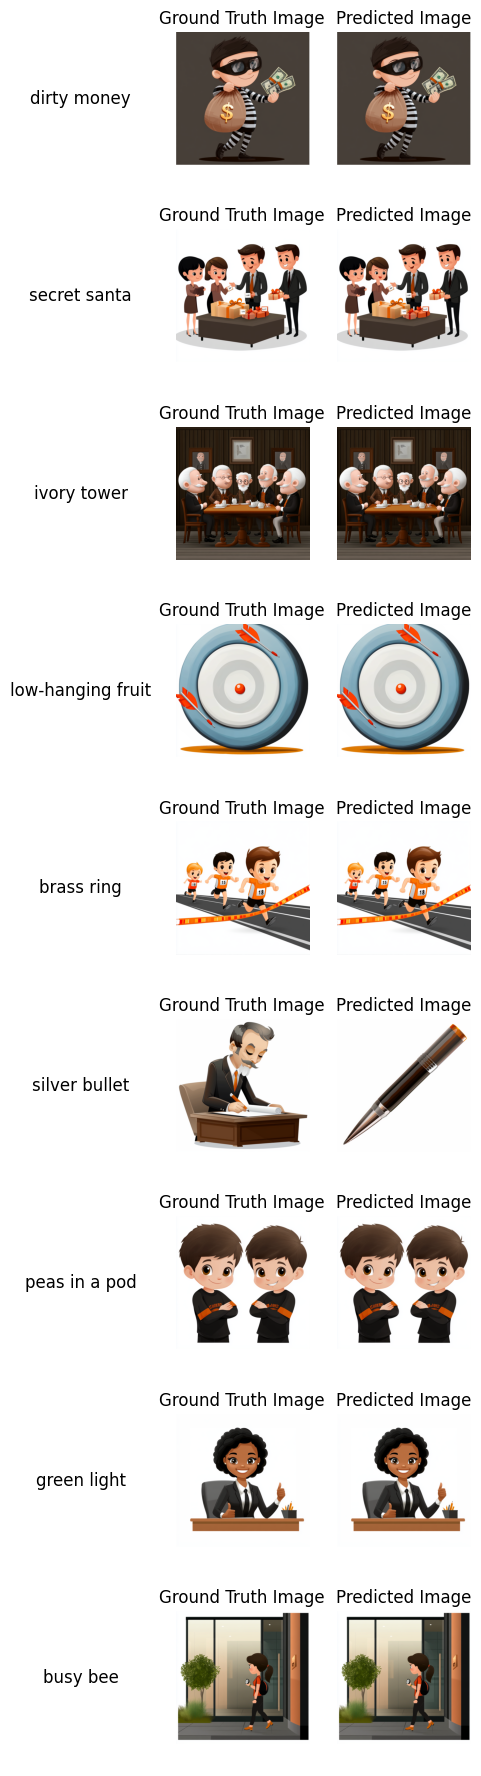

In [ ]:
visualize_predictions(df, test_image_folder)

### 4.2 CLIP model fine-tuning with imbalance augmented dataset

#### 4.2.1 Load CLIP model

In [ ]:
class CLIPFineTuner(nn.Module):
    def __init__(self, model, num_classes):
        super(CLIPFineTuner, self).__init__()
        self.model = model

        # Linear layers to project image and text embeddings into a common space
        self.image_proj = nn.Linear(model.visual.output_dim, 512)  # Project image features
        self.text_proj = nn.Linear(model.text_projection.shape[0], 512)  # Project text features

        # Classifier to predict the label based on concatenated features
        self.classifier = nn.Linear(512 * 3, num_classes)  # Concatenating image, idiom, and caption features

    def forward(self, image, idiom_tokens, caption_tokens):
        # Encode image features
        with torch.no_grad():
            image_features = self.model.encode_image(image).float()

        # Encode idiom and caption
        with torch.no_grad():
            idiom_features = self.model.encode_text(idiom_tokens).float()
            caption_features = self.model.encode_text(caption_tokens).float()

        # Project features into a common space
        image_features = self.image_proj(image_features)
        idiom_features = self.text_proj(idiom_features)
        caption_features = self.text_proj(caption_features)

        # Concatenate features
        combined_features = torch.cat([image_features, idiom_features, caption_features], dim=1)

        # Pass through classifier
        return self.classifier(combined_features)

In [ ]:
# OpenAI CLIP model and preprocessing
model, preprocess = clip.load("ViT-B/32", jit=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [ ]:
num_classes = 2  # Binary classification (correct/incorrect)
model_ft = CLIPFineTuner(model, num_classes).to(device)

#### 4.2.2 Preprocessing the dataset

In [ ]:
class IdiomDataset(Dataset):
    def __init__(self, df, image_folder):
        self.df = df
        self.image_folder = image_folder
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # CLIP expects 224x224 images
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                                 (0.26862954, 0.26130258, 0.27577711))
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load and preprocess image
        image_path = f"{self.image_folder}/{row['image_name']}"
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)  # Apply transformations

        # Tokenize conpound + context
        idiom_text = f"{row['compound']}: {row['sentence']}"
        tokenized_idiom = clip.tokenize([idiom_text])[0]

        # Tokenize caption with truncation
        caption_text = row["image_caption"]
        tokenized_caption = clip.tokenize([caption_text], truncate=True)[0]

        # Convert label to tensor
        label = torch.tensor(row["label"], dtype=torch.long)

        return image, tokenized_idiom, tokenized_caption, label

In [ ]:
# Load dataset
augmented_df = pd.read_csv("/content/drive/MyDrive/CSC8645_Chatwipa/TASK 2/dataset/imbalanced_train_augmented.csv")
val_df = pd.read_csv("/content/dataset/val/val.csv")

# Create train and validation datasets
train_dataset = IdiomDataset(augmented_df, image_folder ="/content/dataset/train/images")
val_dataset = IdiomDataset(val_df, image_folder ="/content/dataset/val/images")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

#### 4.2.3 Define loss and optimizer

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.classifier.parameters(), lr=1e-4)

#### 4.2.4 Fine-Tuning CLIP Model

In [ ]:
save_path = "/content/drive/MyDrive/CSC8645_Chatwipa/TASK 2/model"
date = datetime.today().strftime('%Y-%m-%d')

In [ ]:
# Number of epochs for training
num_epochs = 10
previous_acc = 0

for epoch in range(num_epochs):
    model_ft.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss for the current epoch
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")  # Initialize progress bar

    # Training
    for images, idioms, captions, labels in pbar:
        images, idioms, captions, labels = images.to(device), idioms.to(device), captions.to(device), labels.to(device)

        # Clear previous gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model_ft(images, idioms, captions)

        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters
        running_loss += loss.item()  # Track loss
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')  # Print avg loss

    # Validation
    model_ft.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, idioms, captions, labels in val_loader:
            images, idioms, captions, labels = images.to(device), idioms.to(device), captions.to(device), labels.to(device)

            outputs = model_ft(images, idioms, captions)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f'Validation Accuracy: {val_accuracy:.2f}%')

    # Save model if highest accuracy
    if val_accuracy >= previous_acc:
        previous_acc = val_accuracy
        torch.save(model_ft.state_dict(), f'{save_path}/imbalance_augmented_clip_finetuned_{date}.pth')
        print("Model saved!")

Epoch 1/10, Loss: 0.5983: 100%|██████████| 130/130 [01:17<00:00,  1.68it/s]


Epoch [1/10], Loss: 0.5983
Validation Accuracy: 77.78%
Model saved!


Epoch 2/10, Loss: 0.5225: 100%|██████████| 130/130 [01:18<00:00,  1.66it/s]


Epoch [2/10], Loss: 0.5225
Validation Accuracy: 70.37%


Epoch 3/10, Loss: 0.4718: 100%|██████████| 130/130 [01:17<00:00,  1.68it/s]


Epoch [3/10], Loss: 0.4718
Validation Accuracy: 77.78%
Model saved!


Epoch 4/10, Loss: 0.4359: 100%|██████████| 130/130 [01:18<00:00,  1.65it/s]


Epoch [4/10], Loss: 0.4359
Validation Accuracy: 77.78%
Model saved!


Epoch 5/10, Loss: 0.4083: 100%|██████████| 130/130 [01:17<00:00,  1.67it/s]


Epoch [5/10], Loss: 0.4083
Validation Accuracy: 81.48%
Model saved!


Epoch 6/10, Loss: 0.3851: 100%|██████████| 130/130 [01:18<00:00,  1.67it/s]


Epoch [6/10], Loss: 0.3851
Validation Accuracy: 81.48%
Model saved!


Epoch 7/10, Loss: 0.3666: 100%|██████████| 130/130 [01:17<00:00,  1.67it/s]


Epoch [7/10], Loss: 0.3666
Validation Accuracy: 81.48%
Model saved!


Epoch 8/10, Loss: 0.3496: 100%|██████████| 130/130 [01:17<00:00,  1.67it/s]


Epoch [8/10], Loss: 0.3496
Validation Accuracy: 77.78%


Epoch 9/10, Loss: 0.3343: 100%|██████████| 130/130 [01:16<00:00,  1.69it/s]


Epoch [9/10], Loss: 0.3343
Validation Accuracy: 81.48%
Model saved!


Epoch 10/10, Loss: 0.3212: 100%|██████████| 130/130 [01:17<00:00,  1.67it/s]


Epoch [10/10], Loss: 0.3212
Validation Accuracy: 77.78%


#### 4.2.5 Model evaluation

In [ ]:
def evaluate(df):
    metrics = {
        "accuracy": accuracy_score(df["label"], df["prediction"]),
        "precision": precision_score(df["label"], df["prediction"]),
        "recall": recall_score(df["label"], df["prediction"]),
        "f1_score": f1_score(df["label"], df["prediction"])
    }
    return metrics

def visualize_predictions(df, image_folder):

  compound = df['compound'].unique()
  num_samples = len(compound)
  sample_df = df[df['compound'].isin(compound)]

  # Create figure for visualization
  fig, axes = plt.subplots(num_samples, 3, figsize=(5, 2 * num_samples))

  for i, comp in enumerate(compound):
      # Ground Truth Image
      ground_truth_img = sample_df[(sample_df['compound'] == compound[i])&(sample_df['label'] == 1)]['image_name'].iloc[0]
      ground_truth_img_path = os.path.join(test_image_folder, ground_truth_img)
      ground_truth = Image.open(ground_truth_img_path)

      # Predicted Image
      predicted_img = sample_df[(sample_df['compound'] == compound[i])&(sample_df['prediction'] == 1)]['image_name'].iloc[0]
      predicted_img_path = os.path.join(test_image_folder, predicted_img)
      predicted = Image.open(predicted_img_path)

      # Display Compound (Text)
      axes[i][0].text(0.5, 0.5, comp, fontsize=12, ha='center', va='center')
      axes[i][0].axis("off")

      # Display Ground Truth Image
      axes[i][1].imshow(ground_truth)
      axes[i][1].set_title("Ground Truth Image")
      axes[i][1].axis("off")

      # Display Predicted Image
      axes[i][2].imshow(predicted)
      axes[i][2].set_title("Predicted Image")
      axes[i][2].axis("off")

  plt.tight_layout()
  plt.show()

def predict_best_image(model, compound, context, image_names, captions, image_folder, transform, device):
    model.eval()  # Set model to evaluation mode

    # Tokenizing the Text Input (Idiomatic Phrase + Context)
    idiom_text = clip.tokenize([f"{compound}: {context}"]).to(device)

    best_score = float('-inf')
    best_image = None

    # Processing Each Image
    for img_name, caption in zip(image_names, captions):
        image_path = f"{image_folder}/{img_name}"
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)  # Apply preprocessing

        # Tokenizing Caption
        caption_text = clip.tokenize([caption], truncate=True).to(device)

        with torch.no_grad():
            output = model(image, idiom_text, caption_text)  # Forward pass
            predicted_score = torch.softmax(output, dim=1)[:, 1].item()  # Probability of "correct" class

        # Track Best Image
        if predicted_score > best_score:
            best_score = predicted_score
            best_image = img_name

    return best_image  # Return the image with the highest "correct" probability

In [ ]:
# Preparing dataset
test_image_folder = "/content/dataset/test/images"
df = pd.read_csv("/content/dataset/test/test.csv")
df.head()

compound sentence_type  \
0   dirty money     idiomatic   
1   dirty money     idiomatic   
2   dirty money     idiomatic   
3  secret santa     idiomatic   
4  secret santa     idiomatic   

                                            sentence       image_name  \
0  When dirty money disappears offshore, it becom...  08230960409.png   
1  When dirty money disappears offshore, it becom...  46913780614.png   
2  When dirty money disappears offshore, it becom...  58491774071.png   
3  She got very annoyed when some wag got her a p...  12319434549.png   
4  She got very annoyed when some wag got her a p...  05850548023.png   

                                       image_caption  label  
0  The image depicts a cartoon character dressed ...      1  
1  The image depicts a one-dollar bill with the p...      0  
2  The image depicts a spray bottle, commonly use...      0  
3  The image depicts a group of four people, two ...      1  
4  The image depicts a person dressed in a Santa ...      0

In [ ]:
predictions = []

for _, group in tqdm(df.groupby(["compound", "sentence"])):
    # Get the sentence and image path
    compound = group["compound"].iloc[0]
    context = group["sentence"].iloc[0]
    image_names = group["image_name"].tolist()
    captions = group["image_caption"].tolist()

    # Predict the best image
    best_image = predict_best_image(model_ft, compound, context, image_names, captions, test_image_folder,
                                        transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                             (0.26862954, 0.26130258, 0.27577711))
    ]),
    device=device)

    # Assign 1 if the predicted image matches the actual correct image, otherwise 0
    predicted_label = (group["image_name"] == best_image).astype(int).tolist()
    predictions.extend(predicted_label)  # Append to the predictions list

# Add predictions as a new column
df["prediction"] = predictions

100%|██████████| 9/9 [00:02<00:00,  4.05it/s]


In [ ]:
evaluate_result = evaluate(df)
print(evaluate_result)

{'accuracy': 0.9259259259259259, 'precision': 0.8888888888888888, 'recall': 0.8888888888888888, 'f1_score': 0.8888888888888888}


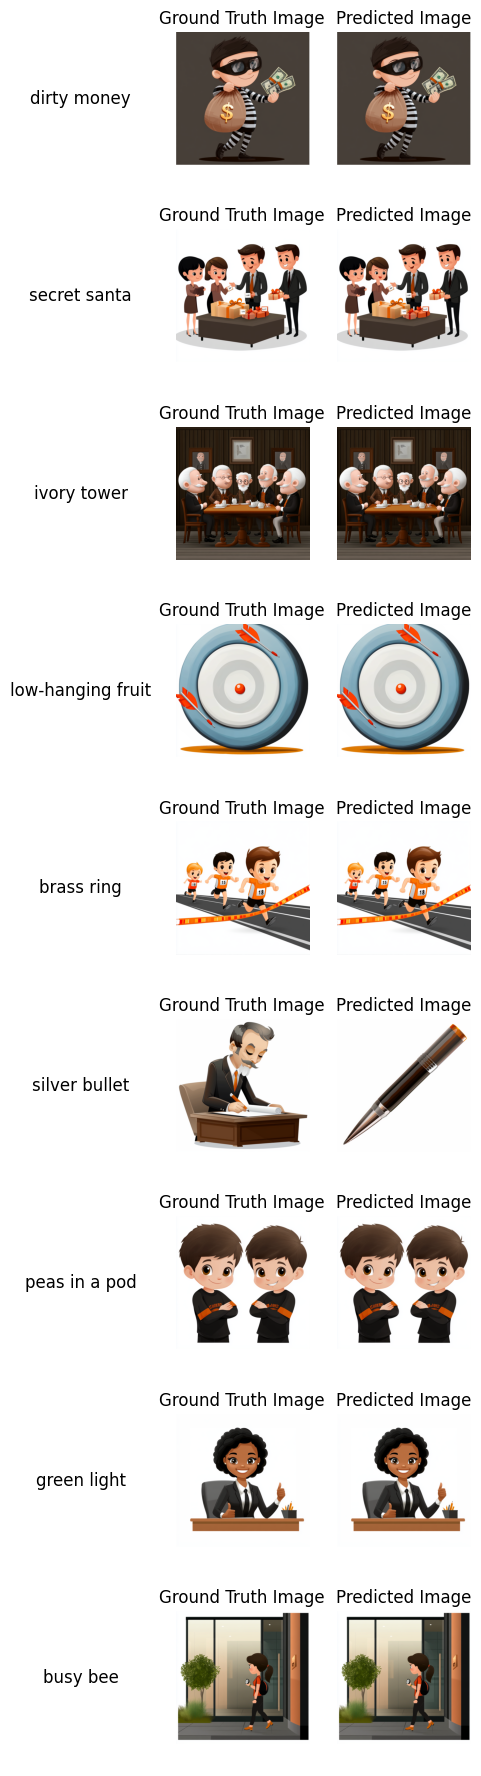

In [ ]:
visualize_predictions(df, test_image_folder)

### 4.3 CLIP model fine-tuning with balance augmented dataset

#### 4.3.1 Load CLIP model

In [ ]:
class CLIPFineTuner(nn.Module):
    def __init__(self, model, num_classes):
        super(CLIPFineTuner, self).__init__()
        self.model = model

        # Linear layers to project image and text embeddings into a common space
        self.image_proj = nn.Linear(model.visual.output_dim, 512)  # Project image features
        self.text_proj = nn.Linear(model.text_projection.shape[0], 512)  # Project text features

        # Classifier to predict the label based on concatenated features
        self.classifier = nn.Linear(512 * 3, num_classes)  # Concatenating image, idiom, and caption features

    def forward(self, image, idiom_tokens, caption_tokens):
        # Encode image features
        with torch.no_grad():
            image_features = self.model.encode_image(image).float()

        # Encode idiom and caption
        with torch.no_grad():
            idiom_features = self.model.encode_text(idiom_tokens).float()
            caption_features = self.model.encode_text(caption_tokens).float()

        # Project features into a common space
        image_features = self.image_proj(image_features)
        idiom_features = self.text_proj(idiom_features)
        caption_features = self.text_proj(caption_features)

        # Concatenate features
        combined_features = torch.cat([image_features, idiom_features, caption_features], dim=1)

        # Pass through classifier
        return self.classifier(combined_features)

In [ ]:
# OpenAI CLIP model and preprocessing
model, preprocess = clip.load("ViT-B/32", jit=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [ ]:
num_classes = 2  # Binary classification (correct/incorrect)
model_ft = CLIPFineTuner(model, num_classes).to(device)

#### 4.3.2 Preprocessing the dataset

In [ ]:
class IdiomDataset(Dataset):
    def __init__(self, df, image_folder):
        self.df = df
        self.image_folder = image_folder
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # CLIP expects 224x224 images
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                                 (0.26862954, 0.26130258, 0.27577711))
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load and preprocess image
        image_path = f"{self.image_folder}/{row['image_name']}"
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)  # Apply transformations

        # Tokenize conpound + context
        idiom_text = f"{row['compound']}: {row['sentence']}"
        tokenized_idiom = clip.tokenize([idiom_text])[0]

        # Tokenize caption with truncation
        caption_text = row["image_caption"]
        tokenized_caption = clip.tokenize([caption_text], truncate=True)[0]

        # Convert label to tensor
        label = torch.tensor(row["label"], dtype=torch.long)

        return image, tokenized_idiom, tokenized_caption, label

In [ ]:
# Load dataset
augmented_df = pd.read_csv("/content/drive/MyDrive/CSC8645_Chatwipa/TASK 2/dataset/balanced_train_augmented.csv")
val_df = pd.read_csv("/content/dataset/val/val.csv")

# Create train and validation datasets
train_dataset = IdiomDataset(augmented_df, image_folder ="/content/dataset/train/images")
val_dataset = IdiomDataset(val_df, image_folder ="/content/dataset/val/images")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

#### 4.3.3 Define loss and optimizer

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.classifier.parameters(), lr=1e-4)

#### 4.3.4 Fine-Tuning CLIP Model

In [ ]:
save_path = "/content/drive/MyDrive/CSC8645_Chatwipa/TASK 2/model"
date = datetime.today().strftime('%Y-%m-%d')

In [ ]:
# Number of epochs for training
num_epochs = 10
previous_acc = 0

for epoch in range(num_epochs):
    model_ft.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss for the current epoch
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")  # Initialize progress bar

    # Training
    for images, idioms, captions, labels in pbar:
        images, idioms, captions, labels = images.to(device), idioms.to(device), captions.to(device), labels.to(device)

        # Clear previous gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model_ft(images, idioms, captions)

        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters
        running_loss += loss.item()  # Track loss
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')  # Print avg loss

    # Validation
    model_ft.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, idioms, captions, labels in val_loader:
            images, idioms, captions, labels = images.to(device), idioms.to(device), captions.to(device), labels.to(device)

            outputs = model_ft(images, idioms, captions)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f'Validation Accuracy: {val_accuracy:.2f}%')

    # Save model if highest accuracy
    if val_accuracy >= previous_acc:
        previous_acc = val_accuracy
        torch.save(model_ft.state_dict(), f'{save_path}/balance_augmented_clip_finetuned_{date}.pth')
        print("Model saved!")

Epoch 1/10, Loss: 0.6628: 100%|██████████| 87/87 [00:50<00:00,  1.71it/s]


Epoch [1/10], Loss: 0.6628
Validation Accuracy: 55.56%
Model saved!


Epoch 2/10, Loss: 0.5946: 100%|██████████| 87/87 [00:52<00:00,  1.67it/s]


Epoch [2/10], Loss: 0.5946
Validation Accuracy: 62.96%
Model saved!


Epoch 3/10, Loss: 0.5437: 100%|██████████| 87/87 [00:52<00:00,  1.67it/s]


Epoch [3/10], Loss: 0.5437
Validation Accuracy: 66.67%
Model saved!


Epoch 4/10, Loss: 0.5053: 100%|██████████| 87/87 [00:52<00:00,  1.67it/s]


Epoch [4/10], Loss: 0.5053
Validation Accuracy: 70.37%
Model saved!


Epoch 5/10, Loss: 0.4754: 100%|██████████| 87/87 [00:51<00:00,  1.67it/s]


Epoch [5/10], Loss: 0.4754
Validation Accuracy: 66.67%


Epoch 6/10, Loss: 0.4504: 100%|██████████| 87/87 [00:50<00:00,  1.71it/s]


Epoch [6/10], Loss: 0.4504
Validation Accuracy: 62.96%


Epoch 7/10, Loss: 0.4298: 100%|██████████| 87/87 [00:50<00:00,  1.71it/s]


Epoch [7/10], Loss: 0.4298
Validation Accuracy: 70.37%
Model saved!


Epoch 8/10, Loss: 0.4116: 100%|██████████| 87/87 [00:51<00:00,  1.68it/s]


Epoch [8/10], Loss: 0.4116
Validation Accuracy: 70.37%
Model saved!


Epoch 9/10, Loss: 0.3950: 100%|██████████| 87/87 [00:52<00:00,  1.67it/s]


Epoch [9/10], Loss: 0.3950
Validation Accuracy: 70.37%
Model saved!


Epoch 10/10, Loss: 0.3806: 100%|██████████| 87/87 [00:52<00:00,  1.67it/s]


Epoch [10/10], Loss: 0.3806
Validation Accuracy: 70.37%
Model saved!


#### 4.3.5 Model evaluation

In [ ]:
def evaluate(df):
    metrics = {
        "accuracy": accuracy_score(df["label"], df["prediction"]),
        "precision": precision_score(df["label"], df["prediction"]),
        "recall": recall_score(df["label"], df["prediction"]),
        "f1_score": f1_score(df["label"], df["prediction"])
    }
    return metrics

def visualize_predictions(df, image_folder):

  compound = df['compound'].unique()
  num_samples = len(compound)
  sample_df = df[df['compound'].isin(compound)]

  # Create figure for visualization
  fig, axes = plt.subplots(num_samples, 3, figsize=(5, 2 * num_samples))

  for i, comp in enumerate(compound):
      # Ground Truth Image
      ground_truth_img = sample_df[(sample_df['compound'] == compound[i])&(sample_df['label'] == 1)]['image_name'].iloc[0]
      ground_truth_img_path = os.path.join(test_image_folder, ground_truth_img)
      ground_truth = Image.open(ground_truth_img_path)

      # Predicted Image
      predicted_img = sample_df[(sample_df['compound'] == compound[i])&(sample_df['prediction'] == 1)]['image_name'].iloc[0]
      predicted_img_path = os.path.join(test_image_folder, predicted_img)
      predicted = Image.open(predicted_img_path)

      # Display Compound (Text)
      axes[i][0].text(0.5, 0.5, comp, fontsize=12, ha='center', va='center')
      axes[i][0].axis("off")

      # Display Ground Truth Image
      axes[i][1].imshow(ground_truth)
      axes[i][1].set_title("Ground Truth Image")
      axes[i][1].axis("off")

      # Display Predicted Image
      axes[i][2].imshow(predicted)
      axes[i][2].set_title("Predicted Image")
      axes[i][2].axis("off")

  plt.tight_layout()
  plt.show()

def predict_best_image(model, compound, context, image_names, captions, image_folder, transform, device):
    model.eval()  # Set model to evaluation mode

    # Tokenizing the Text Input (Idiomatic Phrase + Context)
    idiom_text = clip.tokenize([f"{compound}: {context}"]).to(device)

    best_score = float('-inf')
    best_image = None

    # Processing Each Image
    for img_name, caption in zip(image_names, captions):
        image_path = f"{image_folder}/{img_name}"
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)  # Apply preprocessing

        # Tokenizing Caption
        caption_text = clip.tokenize([caption], truncate=True).to(device)

        with torch.no_grad():
            output = model(image, idiom_text, caption_text)  # Forward pass
            predicted_score = torch.softmax(output, dim=1)[:, 1].item()  # Probability of "correct" class

        # Track Best Image
        if predicted_score > best_score:
            best_score = predicted_score
            best_image = img_name

    return best_image  # Return the image with the highest "correct" probability

In [ ]:
# Preparing dataset
test_image_folder = "/content/dataset/test/images"
df = pd.read_csv("/content/dataset/test/test.csv")
df.head()

compound sentence_type  \
0   dirty money     idiomatic   
1   dirty money     idiomatic   
2   dirty money     idiomatic   
3  secret santa     idiomatic   
4  secret santa     idiomatic   

                                            sentence       image_name  \
0  When dirty money disappears offshore, it becom...  08230960409.png   
1  When dirty money disappears offshore, it becom...  46913780614.png   
2  When dirty money disappears offshore, it becom...  58491774071.png   
3  She got very annoyed when some wag got her a p...  12319434549.png   
4  She got very annoyed when some wag got her a p...  05850548023.png   

                                       image_caption  label  
0  The image depicts a cartoon character dressed ...      1  
1  The image depicts a one-dollar bill with the p...      0  
2  The image depicts a spray bottle, commonly use...      0  
3  The image depicts a group of four people, two ...      1  
4  The image depicts a person dressed in a Santa ...      0

In [ ]:
predictions = []

for _, group in tqdm(df.groupby(["compound", "sentence"])):
    # Get the sentence and image path
    compound = group["compound"].iloc[0]
    context = group["sentence"].iloc[0]
    image_names = group["image_name"].tolist()
    captions = group["image_caption"].tolist()

    # Predict the best image
    best_image = predict_best_image(model_ft, compound, context, image_names, captions, test_image_folder,
                                        transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                             (0.26862954, 0.26130258, 0.27577711))
    ]),
    device=device)

    # Assign 1 if the predicted image matches the actual correct image, otherwise 0
    predicted_label = (group["image_name"] == best_image).astype(int).tolist()
    predictions.extend(predicted_label)  # Append to the predictions list

# Add predictions as a new column
df["prediction"] = predictions

100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


In [ ]:
evaluate_result = evaluate(df)
print(evaluate_result)

{'accuracy': 0.9259259259259259, 'precision': 0.8888888888888888, 'recall': 0.8888888888888888, 'f1_score': 0.8888888888888888}


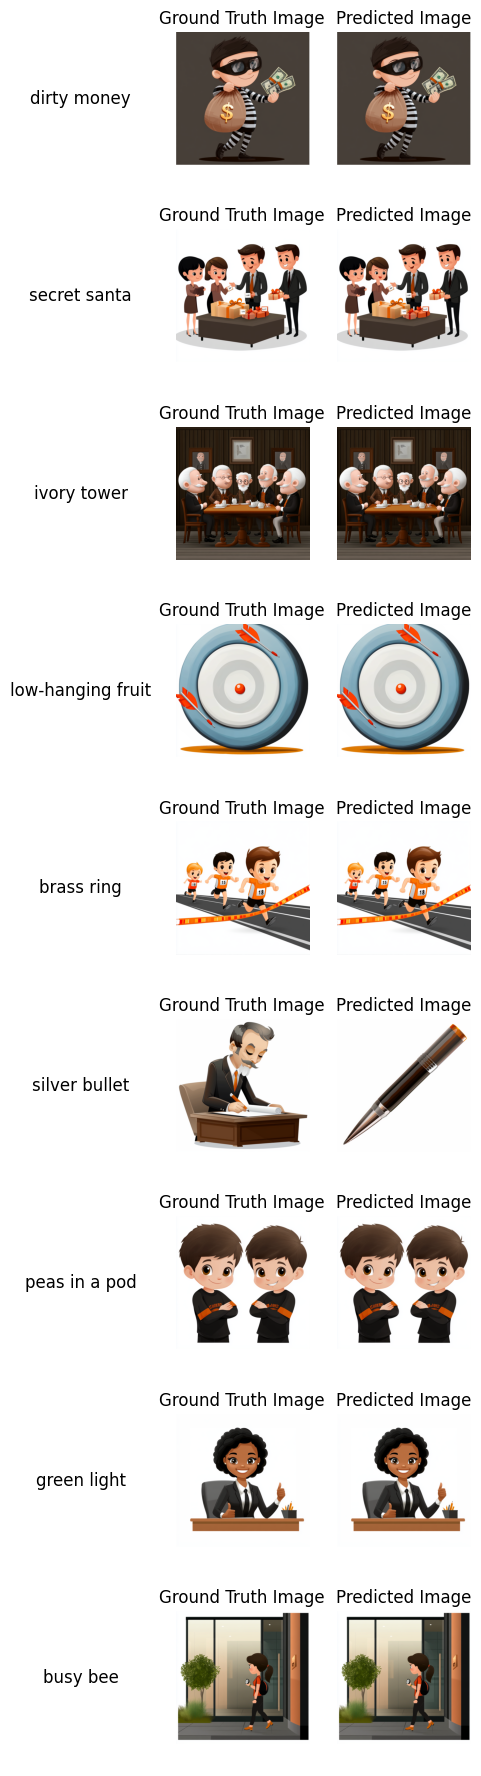

In [ ]:
visualize_predictions(df, test_image_folder)

### 4.4 T5 and ViT Fusion model


#### 4.4.1 Load T5 and ViT model

In [ ]:
# Initialize T5 and ViT models
t5_model = T5ForConditionalGeneration.from_pretrained('t5-small')
t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')

vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')
vit_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
class T5_ViT_Fusion_Model(nn.Module):
    def __init__(self, t5_model, vit_model):
        super(T5_ViT_Fusion_Model, self).__init__()
        self.t5_model = t5_model
        self.vit_model = vit_model
        self.fc = nn.Linear(vit_model.config.hidden_size + t5_model.config.d_model * 2, 2)

    def forward(self, tokenized_idiom, tokenized_caption, image):
        # Process idiom text with T5
        # Idiom input: tokenized_idiom is already tokenized
        text_input_idiom = {"input_ids": tokenized_idiom}
        idiom_features = self.t5_model.encoder(**text_input_idiom)[0][:, 0, :]

        # Process caption text with T5
        # Caption input: tokenized_caption is already tokenized
        text_input_caption = {"input_ids": tokenized_caption}
        caption_features = self.t5_model.encoder(**text_input_caption)[0][:, 0, :]

        # Process image with ViT
        # Access the 'last_hidden_state' attribute for image features
        image_features = self.vit_model.vit(image).last_hidden_state[:, 0, :]

        # Concatenate idiom, caption, and image features
        combined_features = torch.cat((idiom_features, caption_features, image_features), dim=-1)

        # Fully connected classification layer
        output = self.fc(combined_features)
        return output

# Initialize the multimodal model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_T5_ViT = T5_ViT_Fusion_Model(t5_model, vit_model).to(device)

#### 4.3.2 Preprocessing the dataset

In [ ]:
class IdiomDataset_Fusion(Dataset):
    def __init__(self, df, image_folder):
        self.df = df
        self.image_folder = image_folder
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # CLIP expects 224x224 images
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                                 (0.26862954, 0.26130258, 0.27577711))
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load and preprocess image
        image_path = f"{self.image_folder}/{row['image_name']}"
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)  # Apply transformations

        # Compound + context text
        idiom_text = f"{row['compound']}: {row['sentence']}"
        # Tokenize idiom text using T5 tokenizer (or any other tokenizer)
        tokenized_idiom = t5_tokenizer(
            idiom_text,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=128
        ).input_ids.squeeze(0)


        # Caption text
        caption_text = row["image_caption"]
        # Tokenize caption text
        tokenized_caption = t5_tokenizer(
            caption_text,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=128
        ).input_ids.squeeze(0)

        # Convert label to tensor
        label = torch.tensor(row["label"], dtype=torch.long)

        return image, tokenized_idiom, tokenized_caption, label

In [ ]:
# Load dataset
augmented_df = pd.read_csv("/content/drive/MyDrive/CSC8645_Chatwipa/TASK 2/dataset/balanced_train_augmented.csv")
val_df = pd.read_csv("/content/dataset/val/val.csv")

# Create train and validation datasets
train_dataset = IdiomDataset_Fusion(augmented_df, image_folder ="/content/dataset/train/images")
val_dataset = IdiomDataset_Fusion(val_df, image_folder ="/content/dataset/val/images")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

#### 4.3.3 Define loss and optimizer

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_T5_ViT.parameters(), lr=1e-4)

#### 4.3.4 Fine-Tuning T5-ViT Fusion Model

In [ ]:
save_path = "/content/drive/MyDrive/CSC8645_Chatwipa/TASK 2/model"
date = datetime.today().strftime('%Y-%m-%d')

In [ ]:
# Number of epochs for training
num_epochs = 10
previous_acc = 0

# Training loop
for epoch in range(num_epochs):
    model_T5_ViT.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss for the current epoch
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")  # Initialize progress bar

    for images, idioms, captions, labels in pbar:
        images, idioms, captions, labels = images.to(device), idioms.to(device), captions.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear previous gradients

        # Forward pass (pass all required inputs)
        outputs = model_T5_ViT(idioms, captions, images)  # Pass idioms, captions, and images to forward

        # Compute loss (CrossEntropy for classification)
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        running_loss += loss.item()  # Track loss
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

    # Validation
    model_T5_ViT.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, idioms, captions, labels in val_loader:
            images, idioms, captions, labels = images.to(device), idioms.to(device), captions.to(device), labels.to(device)

            outputs = model_T5_ViT(idioms, captions, images)  # Pass idioms, captions, and images to forward
            _, predicted = torch.max(outputs, 1)  # Get the predicted class

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Validation Accuracy: {100 * correct / total:.2f}%')  # Print validation accuracy

    val_accuracy = 100 * correct / total
    # Save model if highest accuracy
    if val_accuracy >= previous_acc:
        previous_acc = val_accuracy
        torch.save(model_ft.state_dict(), f'{save_path}/ViT_T5_finetuned_{date}.pth')
        print("Model saved!")

Epoch 1/10, Loss: 0.0010: 100%|██████████| 87/87 [01:44<00:00,  1.20s/it]


Epoch [1/10], Loss: 0.0010
Validation Accuracy: 70.37%
Model saved!


Epoch 2/10, Loss: 0.0008: 100%|██████████| 87/87 [01:44<00:00,  1.20s/it]


Epoch [2/10], Loss: 0.0008
Validation Accuracy: 70.37%
Model saved!


Epoch 3/10, Loss: 0.0007: 100%|██████████| 87/87 [01:44<00:00,  1.20s/it]


Epoch [3/10], Loss: 0.0007
Validation Accuracy: 70.37%
Model saved!


Epoch 4/10, Loss: 0.0006: 100%|██████████| 87/87 [01:44<00:00,  1.21s/it]


Epoch [4/10], Loss: 0.0006
Validation Accuracy: 70.37%
Model saved!


Epoch 5/10, Loss: 0.0005: 100%|██████████| 87/87 [01:44<00:00,  1.20s/it]


Epoch [5/10], Loss: 0.0005
Validation Accuracy: 70.37%
Model saved!


Epoch 6/10, Loss: 0.0005: 100%|██████████| 87/87 [01:46<00:00,  1.23s/it]


Epoch [6/10], Loss: 0.0005
Validation Accuracy: 70.37%
Model saved!


Epoch 7/10, Loss: 0.0004: 100%|██████████| 87/87 [01:48<00:00,  1.25s/it]


Epoch [7/10], Loss: 0.0004
Validation Accuracy: 70.37%
Model saved!


Epoch 8/10, Loss: 0.0004: 100%|██████████| 87/87 [01:48<00:00,  1.25s/it]


Epoch [8/10], Loss: 0.0004
Validation Accuracy: 70.37%
Model saved!


Epoch 9/10, Loss: 0.0003: 100%|██████████| 87/87 [01:47<00:00,  1.24s/it]


Epoch [9/10], Loss: 0.0003
Validation Accuracy: 70.37%
Model saved!


Epoch 10/10, Loss: 0.0003: 100%|██████████| 87/87 [01:48<00:00,  1.24s/it]


Epoch [10/10], Loss: 0.0003
Validation Accuracy: 70.37%
Model saved!


#### 4.3.5 Model evaluation

In [ ]:
# Preparing dataset
test_image_folder = "/content/dataset/test/images"
df = pd.read_csv("/content/dataset/test/test.csv")
df.head()

compound sentence_type  \
0   dirty money     idiomatic   
1   dirty money     idiomatic   
2   dirty money     idiomatic   
3  secret santa     idiomatic   
4  secret santa     idiomatic   

                                            sentence       image_name  \
0  When dirty money disappears offshore, it becom...  08230960409.png   
1  When dirty money disappears offshore, it becom...  46913780614.png   
2  When dirty money disappears offshore, it becom...  58491774071.png   
3  She got very annoyed when some wag got her a p...  12319434549.png   
4  She got very annoyed when some wag got her a p...  05850548023.png   

                                       image_caption  label  
0  The image depicts a cartoon character dressed ...      1  
1  The image depicts a one-dollar bill with the p...      0  
2  The image depicts a spray bottle, commonly use...      0  
3  The image depicts a group of four people, two ...      1  
4  The image depicts a person dressed in a Santa ...      0

In [ ]:
def predict_best_image(model, compound, context, image_names, captions, image_folder, transform, device):
    model.eval()  # Set model to evaluation mode

    # Tokenizing the Text Input (Idiomatic Phrase + Context) using T5 tokenizer
    idiom_text = f"{compound}: {context}"
    # Remove squeeze(0) to keep batch dimension even if it's 1
    tokenized_idiom = t5_tokenizer(idiom_text, return_tensors="pt", padding="max_length", truncation=True, max_length=128).input_ids.to(device)

    best_score = float('-inf')
    best_image = None

    # Processing Each Image
    for img_name, caption in zip(image_names, captions):
        image_path = f"{image_folder}/{img_name}"
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)  # Apply preprocessing

        # Tokenizing Caption using T5 tokenizer
        # Remove squeeze(0) to keep batch dimension even if it's 1
        tokenized_caption = t5_tokenizer(caption, return_tensors="pt", padding="max_length", truncation=True, max_length=128).input_ids.to(device)

        with torch.no_grad():
            # Pass inputs in the correct order: tokenized_idiom, tokenized_caption, image
            output = model(tokenized_idiom, tokenized_caption, image)
            predicted_score = torch.softmax(output, dim=1)[:, 1].item()  # Probability of "correct" class

        # Track Best Image
        if predicted_score > best_score:
            best_score = predicted_score
            best_image = img_name

    return best_image  # Return the image with the highest "correct" probability

def visualize_predictions(df, image_folder):

  compound = df['compound'].unique()
  num_samples = len(compound)
  sample_df = df[df['compound'].isin(compound)]

  # Create figure for visualization
  fig, axes = plt.subplots(num_samples, 3, figsize=(5, 2 * num_samples))

  for i, comp in enumerate(compound):
      # Ground Truth Image
      ground_truth_img = sample_df[(sample_df['compound'] == compound[i])&(sample_df['label'] == 1)]['image_name'].iloc[0]
      ground_truth_img_path = os.path.join(test_image_folder, ground_truth_img)
      ground_truth = Image.open(ground_truth_img_path)

      # Predicted Image
      predicted_img = sample_df[(sample_df['compound'] == compound[i])&(sample_df['prediction'] == 1)]['image_name'].iloc[0]
      predicted_img_path = os.path.join(test_image_folder, predicted_img)
      predicted = Image.open(predicted_img_path)

      # Display Compound (Text)
      axes[i][0].text(0.5, 0.5, comp, fontsize=12, ha='center', va='center')
      axes[i][0].axis("off")

      # Display Ground Truth Image
      axes[i][1].imshow(ground_truth)
      axes[i][1].set_title("Ground Truth Image")
      axes[i][1].axis("off")

      # Display Predicted Image
      axes[i][2].imshow(predicted)
      axes[i][2].set_title("Predicted Image")
      axes[i][2].axis("off")

  plt.tight_layout()
  plt.show()

In [ ]:
predictions = []

for _, group in tqdm(df.groupby(["compound", "sentence"])):
    # Get the sentence and image path
    compound = group["compound"].iloc[0]
    context = group["sentence"].iloc[0]
    image_names = group["image_name"].tolist()
    captions = group["image_caption"].tolist()

    # Predict the best image
    best_image = predict_best_image(model_T5_ViT, compound, context, image_names, captions, test_image_folder,
                                        transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                             (0.26862954, 0.26130258, 0.27577711))
    ]),
    device=device)

    # Assign 1 if the predicted image matches the actual correct image, otherwise 0
    predicted_label = (group["image_name"] == best_image).astype(int).tolist()
    predictions.extend(predicted_label)  # Append to the predictions list

# Add predictions as a new column
df["prediction"] = predictions

100%|██████████| 9/9 [00:01<00:00,  5.20it/s]


In [ ]:
evaluate_result = evaluate(df)
print(evaluate_result)

{'accuracy': 0.9259259259259259, 'precision': 0.8888888888888888, 'recall': 0.8888888888888888, 'f1_score': 0.8888888888888888}


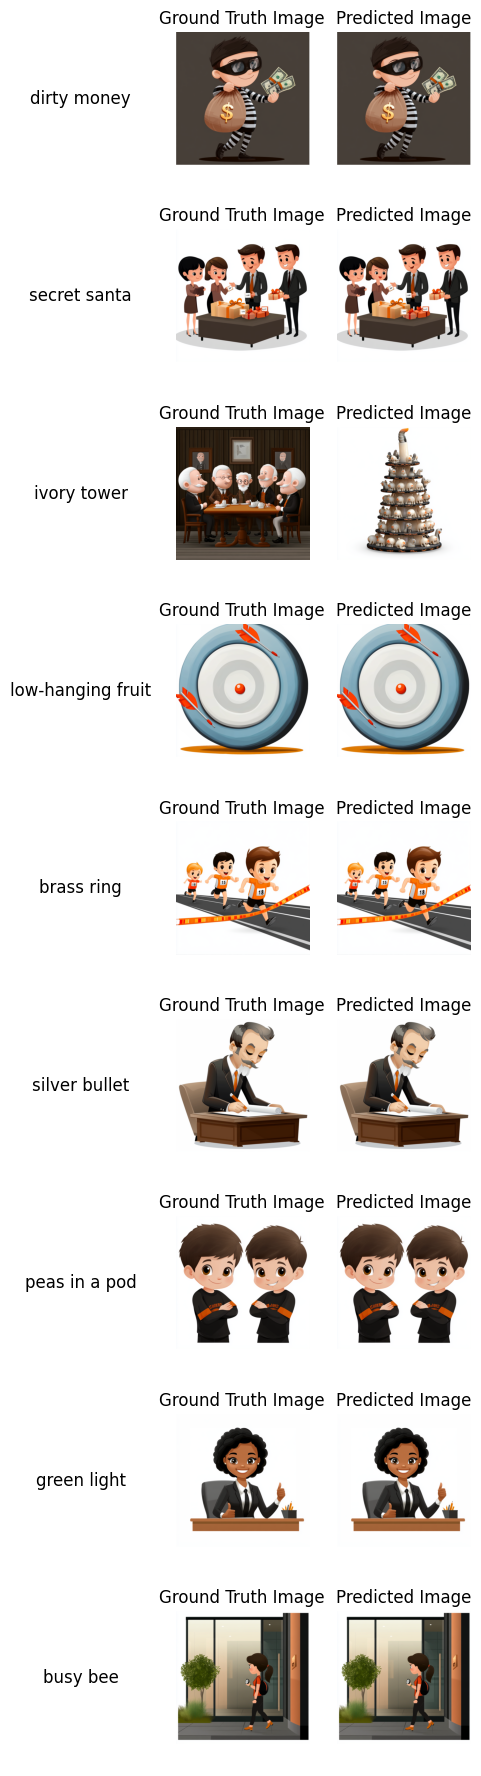

In [ ]:
visualize_predictions(df, test_image_folder)

# 5. Demonstration session

#### 5.1 Data preparation

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Preparing dataset
test_image_folder = "/content/drive/MyDrive/CSC8645_Chatwipa/TASK 2/demo_test/images"
# If the test set does not come with .csv file
df = pd.read_excel("/content/drive/MyDrive/CSC8645_Chatwipa/TASK 2/demo_test/test.xlsx")
# # If the test set come with .csv file
# df = pd.read_csv("/content/drive/MyDrive/CSC8645_Chatwipa/TASK 2/demo_test/test.csv")

### 5.2 Model preparation

In [5]:
class CLIPFineTuner(nn.Module):
    def __init__(self, model, num_classes):
        super(CLIPFineTuner, self).__init__()
        self.model = model

        # Linear layers to project image and text embeddings into a common space
        self.image_proj = nn.Linear(model.visual.output_dim, 512)  # Project image features
        self.text_proj = nn.Linear(model.text_projection.shape[0], 512)  # Project text features

        # Classifier to predict the label based on concatenated features
        self.classifier = nn.Linear(512 * 3, num_classes)  # Concatenating image, idiom, and caption features

    def forward(self, image, idiom_tokens, caption_tokens):
        # Encode image features
        with torch.no_grad():
            image_features = self.model.encode_image(image).float()

        # Encode idiom and caption
        with torch.no_grad():
            idiom_features = self.model.encode_text(idiom_tokens).float()
            caption_features = self.model.encode_text(caption_tokens).float()

        # Project features into a common space
        image_features = self.image_proj(image_features)
        idiom_features = self.text_proj(idiom_features)
        caption_features = self.text_proj(caption_features)

        # Concatenate features
        combined_features = torch.cat([image_features, idiom_features, caption_features], dim=1)

        # Pass through classifier
        return self.classifier(combined_features)

In [6]:
model_path = '/content/drive/MyDrive/CSC8645_Chatwipa/TASK 2/model/imbalance_augmented_clip_finetuned_2025-03-30.pth'

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"

# Instead of using clip.load(), initialize your CLIPFineTuner class
num_classes = 2  # Assuming you have 2 classes in your fine-tuning setup
model = CLIPFineTuner(model=clip.load("ViT-B/32", device=device, jit=False)[0], num_classes=num_classes).to(device) # Initialize your fine-tuned model

# Load the saved state_dict
checkpoint = torch.load(model_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Load fine-tuned weights using the state_dict
model.load_state_dict(checkpoint, strict=True)

model.to(device)
model.eval()

CLIPFineTuner(
  (model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): Sequential(
          (0): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): QuickGELU()
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          )
          (1): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantiza

### 5.3 Model evaluation

In [7]:
def evaluate(df):
    metrics = {
        "accuracy": accuracy_score(df["label"], df["prediction"]),
        "precision": precision_score(df["label"], df["prediction"]),
        "recall": recall_score(df["label"], df["prediction"]),
        "f1_score": f1_score(df["label"], df["prediction"])
    }
    return metrics

def visualize_predictions(df, image_folder):

  compound = df['compound'].unique()
  num_samples = len(compound)
  sample_df = df[df['compound'].isin(compound)]

  # Create figure for visualization
  fig, axes = plt.subplots(num_samples, 3, figsize=(5, 2 * num_samples))

  for i, comp in enumerate(compound):
      # Ground Truth Image
      ground_truth_img = sample_df[(sample_df['compound'] == compound[i])&(sample_df['label'] == 1)]['image_name'].iloc[0]
      ground_truth_img_path = os.path.join(test_image_folder, ground_truth_img)
      ground_truth = Image.open(ground_truth_img_path)

      # Predicted Image
      predicted_img = sample_df[(sample_df['compound'] == compound[i])&(sample_df['prediction'] == 1)]['image_name'].iloc[0]
      predicted_img_path = os.path.join(test_image_folder, predicted_img)
      predicted = Image.open(predicted_img_path)

      # Display Compound (Text)
      axes[i][0].text(0.5, 0.5, comp, fontsize=12, ha='center', va='center')
      axes[i][0].axis("off")

      # Display Ground Truth Image
      axes[i][1].imshow(ground_truth)
      axes[i][1].set_title("Ground Truth Image")
      axes[i][1].axis("off")

      # Display Predicted Image
      axes[i][2].imshow(predicted)
      axes[i][2].set_title("Predicted Image")
      axes[i][2].axis("off")

  plt.tight_layout()
  plt.show()

def predict_best_image(model, compound, context, image_names, captions, image_folder, transform, device):
    model.eval()  # Set model to evaluation mode

    # Tokenizing the Text Input (Idiomatic Phrase + Context)
    idiom_text = clip.tokenize([f"{compound}: {context}"]).to(device)

    best_score = float('-inf')
    best_image = None

    # Processing Each Image
    for img_name, caption in zip(image_names, captions):
        image_path = f"{image_folder}/{img_name}"
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)  # Apply preprocessing

        # Tokenizing Caption
        caption_text = clip.tokenize([caption], truncate=True).to(device)

        with torch.no_grad():
            output = model(image, idiom_text, caption_text)  # Forward pass
            predicted_score = torch.softmax(output, dim=1)[:, 1].item()  # Probability of "correct" class

        # Track Best Image
        if predicted_score > best_score:
            best_score = predicted_score
            best_image = img_name

    return best_image  # Return the image with the highest "correct" probability

In [8]:
predictions = []

for _, group in tqdm(df.groupby(["compound", "sentence"])):
    # Get the sentence and image path
    compound = group["compound"].iloc[0]
    context = group["sentence"].iloc[0]
    image_names = group["image_name"].tolist()
    captions = group["image_caption"].tolist()

    # Predict the best image
    best_image = predict_best_image(model, compound, context, image_names, captions, test_image_folder,
                                        transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                             (0.26862954, 0.26130258, 0.27577711))
    ]),
    device=device)

    # Assign 1 if the predicted image matches the actual correct image, otherwise 0
    predicted_label = (group["image_name"] == best_image).astype(int).tolist()
    predictions.extend(predicted_label)  # Append to the predictions list

# Add predictions as a new column
df["prediction"] = predictions

100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


In [9]:
evaluate_result = evaluate(df)
print(evaluate_result)

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}


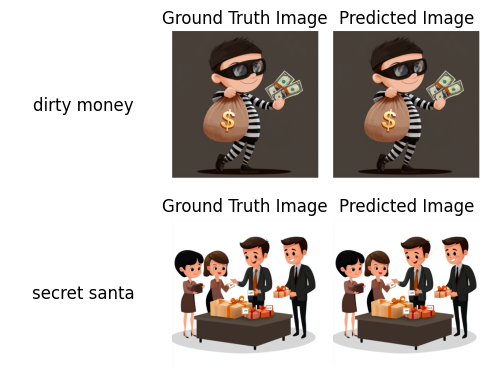

In [10]:
visualize_predictions(df, test_image_folder)